#**CHAPTER 4.LONG CONTEXT RETRIEVAL AND MEMORY ARCHITECTURES**
---

##0.REFERENCE

https://chatgpt.com/share/69851f8d-46f8-8012-bec7-4788b6516df0

##1.CONTEXT

**INTRODUCTION  What this notebook does**

This notebook is a controlled companion experiment for **AI 2026 — Paper 4 (Chapter 4): Long-Context, Retrieval, and Memory Architectures**. Its purpose is not to demonstrate a production system, and it does not claim to model any specific large language model. Instead, it isolates a governance-relevant mechanism that becomes central the moment LLMs are embedded in professional finance workflows: the difference between **having evidence available** and **using evidence correctly under review constraints**.

The practical motivation is straightforward. Modern finance organizations operate inside dense and messy information environments. Numeric claims—revenues, EBITDA, leverage, cash flow, covenant thresholds—do not appear only once. They appear in audited schedules, internal drafts, management decks, guidance narratives, board materials, peer comparisons, rolling-quarter summaries, and stitched tables whose lineage is often unclear. In real organizations, it is normal for multiple versions of “the same number” to circulate, and it is equally normal for those versions to disagree. Sometimes they disagree because a figure is still being finalized. Sometimes they disagree because units changed, currency was converted, or the reporting period shifted. Sometimes they disagree because a table mixes peer data with the focal company and labels become ambiguous. The important point is that disagreement is not an edge case; it is a structural feature of institutional information flow.

Long-context and retrieval architectures are often proposed as solutions to this complexity. The intuition is attractive: if the model sees more context, it will be less likely to miss the correct information. If retrieval is used, the model will see the most relevant information without being overwhelmed. But in governed settings, that intuition is incomplete. Adding more context can add more distractors. Retrieval can omit the authoritative record. Even when the correct record is present, the model’s effective evidence may be a different record. These are not theoretical concerns; they are precisely the failure modes that create silent risk in any system that produces numeric claims intended to be used inside institutional decision processes.

The notebook therefore constructs a synthetic “financial disclosure” ecosystem to make these risks measurable. It generates short synthetic documents with explicit structure: company, quarter, metric, and a numeric value. For each (company, quarter, metric) triple there is one authoritative record that plays the role of the ground truth. Around that authoritative record, the notebook generates several non-authoritative documents that are plausible but wrong. Each distractor is designed to mirror a realistic failure pattern: drafts that should not be cited; guidance figures that are not realized outcomes; unit errors that multiply or divide by ten; wrong-quarter references that carry stale information forward; and peer-table leakage that misattributes a competitor’s number to the target company.

This synthetic design matters because it decouples the core mechanism from any real data. We are not studying a particular company or an empirical macro regime. We are studying a structural question: how does an evidence-handling architecture behave when the evidence set contains plausible conflicts and non-authoritative sources? The notebook’s synthetic environment is intentionally transparent: the reader can inspect exactly how documents were generated and exactly what constitutes “truth.” That transparency is a key governance property. If the mechanism cannot be demonstrated in a fully auditable synthetic setting, it is unlikely to be manageable in real institutional settings.

With this environment in place, the notebook compares two pipelines. The first is a stylized long-context approach: select a large set of documents, treat them as “in context,” and apply a brittle extractor that returns the first matching document. The brittleness is intentional. It acts as a simplified proxy for a broader class of failures in LLM systems where ordering, salience, or heuristic matching dominate evidence selection. In real systems, the mechanism may not be literally “first match,” but the effect can be similar: the system latches onto an early plausible source, even when a more authoritative source is available. This pipeline is designed to expose **context dilution**: as the number of documents grows, the probability that a wrong-but-plausible document becomes the effective evidence increases.

The second pipeline is a retrieval-first approach. The notebook implements a minimal TF–IDF retriever from scratch to select the top-k documents for a query, then applies the same extractor to the reduced evidence set. Retrieval is not presented as a magic fix; it is presented as a different risk profile. Retrieval can reduce dilution by shrinking the candidate set, and it can improve review feasibility because a smaller evidence bundle is easier to inspect. But retrieval also introduces **omission risk**: if the authoritative record is not retrieved, the answer can be wrong while still appearing well-supported within the retrieved subset. Moreover, retrieval can create “thin evidence” conditions where similarity margins are small and the ranking is ambiguous. In such cases, governance should prefer abstention or escalation rather than confident claims.

A distinguishing feature of this notebook is that it treats auditability as a measurable object. It introduces an **Evidence Ledger** that records, for each answer: the candidate evidence set, ranking scores (if retrieval), which document was used, whether that document was authoritative, and whether the candidate set contained materially conflicting values. It also defines reviewer burden proxies that increase with the size of the evidence set and with the presence of material conflicts. These are stylized metrics, not regulatory standards. The value lies in the discipline: governance is operationalized into explicit artifacts and measurable indicators rather than implied by narrative.

The notebook’s evaluation is therefore multi-dimensional. It measures accuracy, but it also measures audited grounding (how often answers are grounded in authoritative records), conflict exposure (how often the evidence set contains materially divergent values), and review burden (a proxy for whether a human reviewer can realistically audit the evidence path). It then constructs governance artifacts—a risk register, evaluation checklist, and control memo—that map observed metrics to control triggers and minimum control sets. This is intentionally aligned with how institutional model risk management operates: risks are documented, indicators are defined, controls are mapped, and outputs are packaged into auditable bundles with manifests and hashes.

For a PhD-finance and PhD-business audience, the notebook’s core contribution is not technical novelty; it is analytic clarity about a mechanism that is easy to underestimate. “More context” can degrade evidence discipline. “Retrieval” can create omission risk. Provenance can be illusory unless the evidence path is logged. And review feasibility is a constraint, not an afterthought. These points are familiar in other areas of finance: they resemble the difference between having data available and having data lineage; between having a model output and having model governance; between having a backtest result and having a reproducible research package with assumptions, controls, and sign-off.

The notebook is therefore a controlled experiment in how to think about long-context and retrieval architectures under governance constraints. It is synthetic by design and non-deployable by declaration. But it aims to be academically rigorous in the sense that its claims are tied to explicit mechanisms, measurable indicators, and auditable artifacts. That is the standard that matters for frontier systems in professional finance: not persuasion by demonstration, but defensibility by design.

**Reminder:** This is illustrative, synthetic, and not validated for real-world use.


##2.LIBRARIES AND ENVIRONMENT

In [1]:
# CELL 2 — Imports, deterministic configuration, and reproducibility metadata (all code)

import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from dataclasses import dataclass
import json
import hashlib
import platform
import sys
import time
from typing import List, Dict, Tuple, Optional

SEED = 20260205
random.seed(SEED)
np.random.seed(SEED)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

def stable_hash(obj) -> str:
    payload = json.dumps(obj, sort_keys=True).encode("utf-8")
    return hashlib.sha256(payload).hexdigest()

ENV_FINGERPRINT = {
    "python_version": sys.version.split()[0],
    "platform": platform.platform(),
    "numpy_version": np.__version__,
    "seed": SEED,
}

def clamp(x: float, lo: float, hi: float) -> float:
    return max(lo, min(hi, x))

print("Environment fingerprint:", ENV_FINGERPRINT)


Environment fingerprint: {'python_version': '3.12.12', 'platform': 'Linux-6.6.105+-x86_64-with-glibc2.35', 'numpy_version': '2.0.2', 'seed': 20260205}


##3.SYNTHETIC CORPUS AND QUERY GENERATION

###3.1.OVERVIEW

**CELL 3 — Synthetic data generation (what is being built and why it matters)**

Cell 3 constructs the entire empirical “world” in which the notebook operates. Because the notebook is governance-first and cannot rely on real data, it must create a synthetic environment that still resembles the structural features of finance-grade document ecosystems. The core object is a synthetic corpus of short “disclosure-like” snippets: each snippet encodes a company identifier, a reporting period, a metric label, and a numeric value. Importantly, the corpus is deliberately not clean. For every (company, quarter, metric) triple there is exactly one authoritative record, and several non-authoritative records that are plausible but wrong. This mirrors the operational reality that finance workflows often involve multiple versions of the “same number” circulating simultaneously (audited schedule vs management deck vs guidance midpoint vs draft model).  

The authoritative record plays the role of a ground truth benchmark for evaluation. But the distractors are the mechanism drivers: they introduce systematic paths to error that are not random noise. Each distractor type corresponds to a failure pattern that is common in financial reporting operations. A “wrong quarter” record mimics stale numbers carried forward or misapplied to the wrong reporting period. A “unit error” record mimics mistakes like mixing millions and billions or inconsistent currency scaling. A “guidance” record mimics forward-looking statements being treated as realized outcomes. A “peer leak” record mimics misattribution from peer tables or comparative summaries. A “draft” record mimics internal drafts that should not be cited.  

In addition to constructing the document corpus, Cell 3 also generates a query set: synthetic questions that resemble how a downstream consumer might ask for specific figures, such as “What is EBITDA for ALPHA in Q2-2024?” The query set is necessary because the notebook is not a free-form demonstration; it is a controlled experiment with repeatable evaluation. Each query carries an embedded “true value” from the authoritative record so that accuracy can be computed exactly and reproducibly.  

The key point is that Cell 3 forces the notebook to confront the governance issue that motivates the paper: in real systems, the risk does not come only from missing information; it comes from having too many plausible-but-inconsistent sources. The synthetic design makes that risk observable and measurable without requiring any real corporate data. This cell therefore sets up the entire rest of the notebook: every later plot and metric is an empirical statement about how evidence-handling architectures behave under controlled but realistic conflict patterns.

**Reminder:** This is illustrative, synthetic, and not validated for real-world use.


###3.2.CODE AND IMPLEMENTATION

In [2]:
# CELL 3 — Synthetic “financial disclosure” corpus and query generation (synthetic only; explicit)

@dataclass(frozen=True)
class Doc:
    doc_id: str
    doc_type: str            # "AUDITED" or "DRAFT"/"GUIDANCE"/"UNIT_ERROR"/"WRONG_Q"/"PEER_LEAK"
    company: str
    quarter: str
    metric: str
    value: float
    text: str
    authoritative: bool

@dataclass(frozen=True)
class Query:
    company: str
    quarter: str
    metric: str
    question: str
    true_value: float

COMPANIES = ["ALPHA", "BETA", "GAMMA", "DELTA", "OMEGA"]
QUARTERS = ["Q1-2024", "Q2-2024", "Q3-2024", "Q4-2024"]
METRICS = ["REVENUE_USD_M", "EBITDA_USD_M", "NET_DEBT_USD_M", "FCF_USD_M"]

def generate_ground_truth() -> Dict[Tuple[str, str, str], float]:
    gt = {}
    for c in COMPANIES:
        # Company scale (stylized)
        scale = random.uniform(80, 600)
        for q in QUARTERS:
            seasonal = random.uniform(0.92, 1.12)
            for m in METRICS:
                if m == "REVENUE_USD_M":
                    v = scale * seasonal * random.uniform(0.85, 1.25)
                elif m == "EBITDA_USD_M":
                    v = scale * seasonal * random.uniform(0.12, 0.48)
                elif m == "NET_DEBT_USD_M":
                    v = scale * random.uniform(0.25, 1.35)
                else:  # FCF_USD_M
                    v = scale * seasonal * random.uniform(-0.10, 0.28)
                gt[(c, q, m)] = float(np.round(v, 2))
    return gt

GROUND_TRUTH = generate_ground_truth()

NOISE_TOPICS = [
    "non-GAAP bridge", "risk factor boilerplate", "segment narrative", "FX sensitivity note",
    "working capital commentary", "capex guidance", "covenant summary", "peer benchmark table"
]

def make_authoritative_doc(c: str, q: str, m: str, v: float, idx: int) -> Doc:
    topic = random.choice(NOISE_TOPICS)
    text = (
        f"Company {c}; Period {q}. Audited schedule reports {m} = {v:.2f}. "
        f"Classification: final. Supporting context: {topic}."
    )
    return Doc(
        doc_id=f"AUD-{idx:05d}",
        doc_type="AUDITED",
        company=c, quarter=q, metric=m, value=v,
        text=text,
        authoritative=True
    )

def make_distractor_doc(c: str, q: str, m: str, true_v: float, idx: int) -> Doc:
    mode = random.choice(["DRAFT", "GUIDANCE", "UNIT_ERROR", "WRONG_Q", "PEER_LEAK"])
    topic = random.choice(NOISE_TOPICS)

    if mode == "WRONG_Q":
        q_alt = random.choice([x for x in QUARTERS if x != q])
        v = GROUND_TRUTH[(c, q_alt, m)]
        text = (
            f"Company {c}; Period {q_alt}. Discussion draft references {m} = {v:.2f}. "
            f"Status: may be stale. Context: {topic}."
        )
        return Doc(f"DST-{idx:05d}", mode, c, q_alt, m, v, text, False)

    if mode == "PEER_LEAK":
        c_alt = random.choice([x for x in COMPANIES if x != c])
        v = GROUND_TRUTH[(c_alt, q, m)]
        text = (
            f"Peer table: {c_alt} vs {c}; Period {q}. The metric {m} = {v:.2f} appears in a peer row. "
            f"Risk: misattribution. Context: {topic}."
        )
        return Doc(f"DST-{idx:05d}", mode, c, q, m, v, text, False)

    if mode == "UNIT_ERROR":
        scale = random.choice([0.1, 10.0])
        v = float(np.round(true_v * scale, 2))
        text = (
            f"Company {c}; Period {q}. Internal deck lists {m} = {v:.2f}. "
            f"Units potentially inconsistent (scale factor). Context: {topic}."
        )
        return Doc(f"DST-{idx:05d}", mode, c, q, m, v, text, False)

    if mode == "GUIDANCE":
        shock = random.uniform(-0.12, 0.12)
        v = float(np.round(true_v * (1.0 + shock), 2))
        text = (
            f"Company {c}; Period {q}. Guidance midpoint suggests {m} ≈ {v:.2f}. "
            f"Forward-looking; not final. Context: {topic}."
        )
        return Doc(f"DST-{idx:05d}", mode, c, q, m, v, text, False)

    # DRAFT
    shock = random.uniform(-0.28, 0.28)
    v = float(np.round(true_v * (1.0 + shock), 2))
    text = (
        f"Company {c}; Period {q}. Draft model output: {m} = {v:.2f}. "
        f"Do not cite; subject to review. Context: {topic}."
    )
    return Doc(f"DST-{idx:05d}", mode, c, q, m, v, text, False)

# Build corpus: 1 authoritative per tuple + multiple distractors
docs: List[Doc] = []
doc_idx = 0
DISTRACTORS_PER_TUPLE = 4

for (c, q, m), v in GROUND_TRUTH.items():
    docs.append(make_authoritative_doc(c, q, m, v, doc_idx)); doc_idx += 1
    for _ in range(DISTRACTORS_PER_TUPLE):
        docs.append(make_distractor_doc(c, q, m, v, doc_idx)); doc_idx += 1

random.shuffle(docs)

# Build query set
N_QUERIES = 300
queries: List[Query] = []
for _ in range(N_QUERIES):
    c = random.choice(COMPANIES)
    q = random.choice(QUARTERS)
    m = random.choice(METRICS)
    tv = GROUND_TRUTH[(c, q, m)]
    question = f"What is {m} for {c} in {q}?"
    queries.append(Query(c, q, m, question, tv))

print("Corpus size:", len(docs))
print("Queries:", len(queries))
print("Example doc:", docs[0].doc_id, docs[0].doc_type, "| authoritative:", docs[0].authoritative)
print("Example query:", queries[0].question, "| true:", queries[0].true_value)


Corpus size: 400
Queries: 300
Example doc: DST-00127 WRONG_Q | authoritative: False
Example query: What is FCF_USD_M for OMEGA in Q4-2024? | true: 92.35


##4.AUDIT GRADE INSTRUMENTATION

###4.1.OVERVIEW

**CELL 4 — Audit-grade instrumentation (why governance requires executable primitives, not prose)**

Cell 4 introduces governance as executable structure. In many notebooks, an “explanation cell” is just narrative. Here, the goal is different: Cell 4 contributes code that makes audit and governance properties measurable and reconstructible. This is crucial because the paper’s thesis is not merely that long contexts can fail, but that they can fail in ways that are hard to review. If the notebook cannot track what evidence was considered, what evidence was used, and whether that evidence disagreed with other plausible evidence, then it cannot demonstrate the governance failure mode at all.  

The central object introduced in Cell 4 is an “Evidence Ledger” concept. A ledger entry is a compact, replayable record of an answer event: the query, the candidate evidence set, the document actually used, whether the used document is authoritative, and a set of diagnostics that quantify disagreement and review burden. The point is not to build an enterprise logging system; it is to define minimal auditable primitives that a governance program would require before trusting any system integrated into a financial workflow.  

Cell 4 also introduces conflict detection as a first-class mechanism. In finance contexts, conflicting figures are normal: draft vs audited, guidance vs realized, stale quarter vs current quarter, and unit inconsistencies. A governance-relevant system needs to identify when conflicts exist, even if it chooses one figure. This cell therefore defines a way to scan the candidate evidence set and compute disagreement statistics such as dispersion and range, then label whether the disagreement is “material” under an explicit threshold rule. The precise threshold is synthetic, but the principle is real: governance requires an explicit definition of what counts as a meaningful discrepancy, and it requires the system to detect it.  

Finally, Cell 4 introduces review burden proxies. Governance is constrained by human attention. A system that requires reviewing hundreds of documents per output is not actually auditable in practice, even if every document is logged. So Cell 4 defines a review-cost proxy that grows with the size of the candidate set and increases when conflicts are material. This is not an economic model of review cost; it is a formal placeholder that forces the notebook to treat “auditability” as something quantifiable rather than rhetorical.  

A subtle but important design choice is that Cell 4 is order-safe: it defines these governance primitives without assuming later cells have already run. This matters operationally because notebooks are often executed out of order, and governance tooling must remain robust under imperfect human execution. In sum, Cell 4 is where the notebook stops being a toy answerer and becomes a controlled governance experiment: it equips later cells to report not just correctness, but evidence discipline, conflict surface, and review feasibility.

**Reminder:** This is illustrative, synthetic, and not validated for real-world use.


###4.2.CODE AND IMPLEMENTATION

In [3]:
# CELL 4 — Audit-grade instrumentation (order-safe): defines ledger + conflict logic WITHOUT assuming Cell 5 exists yet.
# It also runs an optional diagnostic ONLY if the downstream functions are already defined.

from IPython.display import Markdown, display
from typing import Any, List, Dict, Optional
import math
import numpy as np

display(Markdown(
r"""
**Audit-grade instrumentation (order-safe cell):**

This cell contributes executable governance and audit machinery **without relying on later cells**.

It defines a minimal **Evidence Ledger** abstraction and **conflict diagnostics** that can be used by:
- long-context pipelines, and
- retrieval pipelines,

to log: candidate evidence, used evidence, disagreement, and review burden proxies.

A small **self-check** runs only if downstream helpers (e.g., `tokenize`, `parse_metric_value`, `retrieve_topk`) are already available.
If not, the cell remains fully valid and will activate later when those functions exist.

**Reminder:** This is **illustrative**, **synthetic**, and **not validated for real-world use**.
"""
))

# ----------------------------
# Order-safe helper access
# ----------------------------

def _has(name: str) -> bool:
    return name in globals() and globals()[name] is not None

def _call(name: str, *args, **kwargs):
    return globals()[name](*args, **kwargs)

# ----------------------------
# Governance proxies
# ----------------------------

def provenance_visibility_proxy(n_docs: int) -> float:
    # Stylized: evidence traceability declines as candidate evidence grows.
    return 1.0 / max(1, int(n_docs))

def review_cost_proxy(n_candidates: int, has_material_conflict: bool) -> float:
    # Stylized reviewer effort: grows with evidence set size; conflict requires adjudication overhead.
    base = math.log(1.0 + max(0, int(n_candidates)))
    penalty = 1.75 if has_material_conflict else 1.0
    return float(base * penalty)

# ----------------------------
# Conflict diagnostics (works with Doc and Query objects once they exist)
# ----------------------------

def extract_value_if_matches(doc, q) -> Optional[float]:
    """
    Order-safe: If tokenization/parsing helpers exist (Cell 5), use them.
    Otherwise, return None (conflict analysis will be inactive until helpers exist).
    """
    if not (_has("tokenize") and _has("parse_metric_value")):
        return None

    toks = set(_call("tokenize", doc.text))
    if (q.company in toks) and (q.quarter in toks) and (q.metric in toks):
        return _call("parse_metric_value", doc.text, q.metric)
    return None

def conflict_stats(candidate_docs: List[Any], q: Any) -> Dict[str, Any]:
    vals, ids, types = [], [], []
    for d in candidate_docs:
        v = extract_value_if_matches(d, q)
        if v is not None:
            vals.append(float(v))
            ids.append(d.doc_id)
            types.append(getattr(d, "doc_type", "UNKNOWN"))

    if len(vals) == 0:
        return {
            "n_matching_docs": 0,
            "values": [],
            "doc_ids": [],
            "doc_types": [],
            "range": None,
            "std": None,
            "material_conflict": False,
            "materiality_threshold": None
        }

    v_arr = np.array(vals, dtype=float)
    v_range = float(np.max(v_arr) - np.min(v_arr))
    v_std = float(np.std(v_arr))

    # Conservative materiality proxy (generic; metric-specific policies differ in practice):
    # material if range exceeds max(1.0, 2% of median magnitude).
    med_mag = float(np.median(np.abs(v_arr)) + 1e-12)
    threshold = max(1.0, 0.02 * med_mag)
    material = bool(v_range >= threshold)

    return {
        "n_matching_docs": int(len(vals)),
        "values": [float(x) for x in vals],
        "doc_ids": ids,
        "doc_types": types,
        "range": v_range,
        "std": v_std,
        "material_conflict": material,
        "materiality_threshold": float(threshold)
    }

def doc_is_authoritative(doc_id: Optional[str], corpus: List[Any]) -> bool:
    if doc_id is None:
        return False
    for d in corpus:
        if d.doc_id == doc_id:
            return bool(getattr(d, "authoritative", False))
    return False

def evidence_ledger_entry(
    q: Any,
    pipeline_name: str,
    candidate_docs: List[Any],
    used_doc_id: Optional[str],
    pred_value: Optional[float],
    truth_value: float,
    corpus: Optional[List[Any]] = None,
    ranking_scores: Optional[List[float]] = None
) -> Dict[str, Any]:
    """
    Minimal, replayable ledger entry:
      - what was asked
      - what was predicted
      - what evidence was considered and used
      - whether evidence disagreed materially
      - proxies for traceability and review burden
    """
    cstats = conflict_stats(candidate_docs, q)

    # exact_match is defined in Cell 5; fall back to safe check if unavailable
    if _has("exact_match"):
        ex_match = bool(_call("exact_match", pred_value, truth_value))
    else:
        ex_match = (pred_value is not None) and (abs(float(pred_value) - float(truth_value)) <= 1e-6)

    entry = {
        "query": {
            "company": q.company,
            "quarter": q.quarter,
            "metric": q.metric,
            "question": q.question,
            "true_value": float(truth_value),
        },
        "pipeline": pipeline_name,
        "prediction": {
            "pred_value": None if pred_value is None else float(pred_value),
            "exact_match": ex_match,
            "abs_error": None if pred_value is None else float(abs(float(pred_value) - float(truth_value))),
        },
        "evidence": {
            "n_candidates": int(len(candidate_docs)),
            "candidate_doc_ids": [d.doc_id for d in candidate_docs],
            "used_doc_id": used_doc_id,
            "used_doc_authoritative": (doc_is_authoritative(used_doc_id, corpus) if corpus is not None else None),
            "ranking_scores": None if ranking_scores is None else [float(x) for x in ranking_scores],
        },
        "conflicts": cstats,
        "governance_proxies": {
            "provenance_visibility": float(provenance_visibility_proxy(len(candidate_docs))),
            "review_cost_proxy": float(review_cost_proxy(len(candidate_docs), bool(cstats["material_conflict"]))),
        },
        "verification_status": "Not verified"
    }
    return entry

# ----------------------------
# Optional diagnostic (runs only if downstream pipeline helpers exist)
# ----------------------------

if _has("queries") and _has("docs") and _has("brittle_first_match_answer") and _has("retrieve_topk"):
    q_diag = random.choice(queries)

    top_idx_diag, sims_diag = _call("retrieve_topk", q_diag.question, k=12)
    cand_ret = [docs[i] for i in top_idx_diag]
    pred_ret, used_ret = _call("brittle_first_match_answer", cand_ret, q_diag)

    ledger_ret = evidence_ledger_entry(
        q=q_diag,
        pipeline_name="retrieval",
        candidate_docs=cand_ret,
        used_doc_id=used_ret,
        pred_value=pred_ret,
        truth_value=q_diag.true_value,
        corpus=docs,
        ranking_scores=list(sims_diag)
    )

    print("Cell 4 diagnostic ledger (retrieval):")
    print({k: ledger_ret[k] for k in ["pipeline", "prediction", "governance_proxies"]})
    print("Conflict snapshot:", {k: ledger_ret["conflicts"][k] for k in ["n_matching_docs", "range", "material_conflict"]})
else:
    print("Cell 4 loaded (order-safe). Downstream diagnostics will activate after Cell 5 defines retrieval/extraction helpers.")



**Audit-grade instrumentation (order-safe cell):**

This cell contributes executable governance and audit machinery **without relying on later cells**.

It defines a minimal **Evidence Ledger** abstraction and **conflict diagnostics** that can be used by:
- long-context pipelines, and
- retrieval pipelines,

to log: candidate evidence, used evidence, disagreement, and review burden proxies.

A small **self-check** runs only if downstream helpers (e.g., `tokenize`, `parse_metric_value`, `retrieve_topk`) are already available.
If not, the cell remains fully valid and will activate later when those functions exist.

**Reminder:** This is **illustrative**, **synthetic**, and **not validated for real-world use**.


Cell 4 loaded (order-safe). Downstream diagnostics will activate after Cell 5 defines retrieval/extraction helpers.


##5.CORE METHODS

###5.1.OVERVIEW

**CELL 5 — Core mechanism implementation (long-context vs retrieval as evidence-handling architectures)**

Cell 5 implements the core experimental machinery: it defines how the notebook will answer questions using two evidence-handling architectures and how those architectures will be evaluated in a governance-aware way. The cell builds the minimal technical substrate required to replicate the paper’s conceptual distinction between “stuff everything into context” and “select evidence before reasoning.”  

First, the cell defines the tokenizer and numeric parser. This is intentionally simple and auditable: the synthetic documents follow a known structure, so the extraction logic can be transparent. The notebook does not attempt to “understand text” in the NLP sense; it simulates the pipeline stage where a model or tool must pick an evidence snippet and convert it into a numeric claim. The simplicity is deliberate: if the mechanism can fail even under clean parsing, then the failure is about evidence handling, not about fancy language modeling.  

Second, Cell 5 defines a deliberately brittle extractor: it scans the candidate evidence documents in order and returns the first match that contains the relevant company, quarter, and metric tokens. This brittleness is not a mistake; it is a mechanism amplifier. In real systems, ordering and salience effects can cause early matches to dominate reasoning. The “first match” rule is a simplified proxy for a broad class of failures where a system latches onto the first plausible source rather than the most authoritative one. This allows the notebook to demonstrate “context dilution” as an empirical phenomenon: adding more context increases the chance that the first match is wrong.  

Third, Cell 5 implements retrieval using a transparent TF–IDF cosine similarity approach built from scratch. This captures the essence of retrieval pipelines: before answering, the system selects a smaller subset of potentially relevant documents. The cell’s implementation avoids black-box dependencies and makes each step auditable: term counts, document frequencies, inverse document frequencies, normalized vectors, and similarity scoring. Again, the point is not retrieval performance; it is to create a disciplined evidence gate whose behavior can be inspected and stress-tested.  

Finally, Cell 5 integrates the governance instrumentation from Cell 4 by having both pipelines optionally emit an Evidence Ledger entry. This is where the notebook’s academic rigor matters: it ensures that every answer can be reconstructed in terms of candidate set, selected set, used evidence, and conflict diagnostics. That is the key governance improvement over naive “accuracy only” evaluation. Cell 5 therefore establishes the experimental contract for the rest of the notebook: every subsequent visualization and stress test is based on explicit, logged evidence handling rather than opaque outcomes.

**Reminder:** This is illustrative, synthetic, and not validated for real-world use.


###5.2.CODE AND IMPLEMENTATION

In [4]:
# CELL 5 — Core methods (rewritten to integrate the Cell 4 audit ledger + avoid brittle ordering assumptions)
# This cell: (i) defines tokenize/parse/extractor, (ii) builds TF–IDF, (iii) defines both pipelines,
# and (iv) optionally returns an evidence ledger entry per query (finance-grade auditability).

import math
import numpy as np
from collections import Counter
from typing import List, Dict, Tuple, Optional, Any

# ----------------------------
# 5.1 Tokenization + parsing (transparent, deterministic)
# ----------------------------

TOKEN_CHARS = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789_-"

def tokenize(text: str) -> List[str]:
    """
    Uppercase lexical tokenizer tailored to the synthetic corpus format.
    It is intentionally simple and auditable (no external NLP dependencies).
    """
    t = text.upper()
    out, cur = [], []
    for ch in t:
        if ch in TOKEN_CHARS:
            cur.append(ch)
        else:
            if cur:
                out.append("".join(cur))
                cur = []
    if cur:
        out.append("".join(cur))
    return out

def parse_metric_value(doc_text: str, metric: str) -> Optional[float]:
    """
    Parses the numeric token after the exact pattern '{METRIC} = {number}'.
    This is a controlled extractor for synthetic text (NOT a general parser).
    """
    needle = f"{metric} = "
    pos = doc_text.find(needle)
    if pos < 0:
        return None
    start = pos + len(needle)
    end = start
    while end < len(doc_text) and (doc_text[end].isdigit() or doc_text[end] in ".-"):
        end += 1
    try:
        return float(doc_text[start:end])
    except:
        return None

# ----------------------------
# 5.2 Extractor (brittle by design to expose dilution effects)
# ----------------------------

def brittle_first_match_answer(candidate_docs: List[Any], q: Any) -> Tuple[Optional[float], Optional[str]]:
    """
    Returns the first matching value found in candidate_docs.
    Matching requires explicit presence of (company, quarter, metric) tokens.

    IMPORTANT: Brittleness is deliberate — it emulates a class of real failures where
    ordering/salience drives evidence choice, causing dilution under long contexts.
    """
    c_tok, q_tok, m_tok = q.company, q.quarter, q.metric

    for d in candidate_docs:
        toks = set(tokenize(d.text))
        if (c_tok in toks) and (q_tok in toks) and (m_tok in toks):
            v = parse_metric_value(d.text, q.metric)
            if v is not None:
                return v, d.doc_id
    return None, None

def exact_match(pred: Optional[float], truth: float, tol: float = 1e-6) -> bool:
    return (pred is not None) and (abs(float(pred) - float(truth)) <= tol)

# ----------------------------
# 5.3 TF–IDF retrieval (from scratch; auditable)
# ----------------------------

DOC_TOKENS = [tokenize(d.text) for d in docs]
DOC_COUNTS = [Counter(toks) for toks in DOC_TOKENS]

DF = Counter()
for tc in DOC_COUNTS:
    for term in tc:
        DF[term] += 1

N_DOCS = len(docs)
IDF = {term: math.log((N_DOCS + 1) / (df + 1)) + 1.0 for term, df in DF.items()}

VOCAB = sorted(DF.keys())
VOCAB_INDEX = {t: i for i, t in enumerate(VOCAB)}
V = len(VOCAB_INDEX)

def tfidf_vec(term_count: Counter) -> np.ndarray:
    vec = np.zeros(V, dtype=float)
    for term, tf in term_count.items():
        if term in VOCAB_INDEX:
            vec[VOCAB_INDEX[term]] = (1.0 + math.log(tf)) * IDF.get(term, 0.0)
    norm = np.linalg.norm(vec) + 1e-12
    return vec / norm

DOC_VECS = np.vstack([tfidf_vec(tc) for tc in DOC_COUNTS])

def retrieve_topk(query_text: str, k: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Returns (top_indices, similarity_scores) for TF–IDF cosine similarity.
    """
    qtc = Counter(tokenize(query_text))
    qv = tfidf_vec(qtc)
    sims = DOC_VECS @ qv
    top = np.argsort(-sims)[:k]
    return top, sims[top]

# ----------------------------
# 5.4 Pipelines that return both answer and evidence ledger (Cell 4 integration)
# ----------------------------

def pipeline_long_context(
    q: Any,
    context_size: int,
    return_ledger: bool = True
) -> Dict[str, Any]:
    """
    Simulates a long-context prompt by sampling a large candidate set from the corpus.
    Returns prediction + provenance; optionally emits a governance ledger entry.
    """
    idxs = list(range(N_DOCS))
    random.shuffle(idxs)
    idxs = idxs[:context_size]
    candidate_docs = [docs[i] for i in idxs]

    pred, used_doc = brittle_first_match_answer(candidate_docs, q)

    out = {
        "pred": pred,
        "used_doc": used_doc,
        "candidate_docs": candidate_docs,  # kept for auditing; avoid huge prints elsewhere
        "candidate_doc_ids": [d.doc_id for d in candidate_docs],
        "context_size": int(context_size),
    }

    if return_ledger and "evidence_ledger_entry" in globals():
        out["ledger"] = evidence_ledger_entry(
            q=q,
            pipeline_name="long_context",
            candidate_docs=candidate_docs,
            used_doc_id=used_doc,
            pred_value=pred,
            truth_value=q.true_value,
            corpus=docs,
            ranking_scores=None
        )
    return out

def pipeline_retrieval(
    q: Any,
    k: int,
    return_ledger: bool = True
) -> Dict[str, Any]:
    """
    Retrieval-then-extraction pipeline.
    Returns prediction + provenance; optionally emits a governance ledger entry including similarity scores.
    """
    top, sims = retrieve_topk(q.question, k=int(k))
    candidate_docs = [docs[i] for i in top]

    pred, used_doc = brittle_first_match_answer(candidate_docs, q)

    out = {
        "pred": pred,
        "used_doc": used_doc,
        "candidate_docs": candidate_docs,
        "candidate_doc_ids": [d.doc_id for d in candidate_docs],
        "retrieved_sims": [float(x) for x in sims],
        "k": int(k),
    }

    if return_ledger and "evidence_ledger_entry" in globals():
        out["ledger"] = evidence_ledger_entry(
            q=q,
            pipeline_name="retrieval",
            candidate_docs=candidate_docs,
            used_doc_id=used_doc,
            pred_value=pred,
            truth_value=q.true_value,
            corpus=docs,
            ranking_scores=list(sims)
        )
    return out

# ----------------------------
# 5.5 Sanity check (small, interpretable; no long logs)
# ----------------------------

q_check = random.choice(queries)
out_r = pipeline_retrieval(q_check, k=10, return_ledger=True)
out_c = pipeline_long_context(q_check, context_size=80, return_ledger=True)

print("Cell 5 ready. TF–IDF vocab size:", V)
print("Sanity check query:", q_check.question)
print("  truth:", q_check.true_value)
print("  retrieval pred:", out_r["pred"], "| correct:", exact_match(out_r["pred"], q_check.true_value),
      "| used_doc:", out_r["used_doc"])
print("  long-context pred:", out_c["pred"], "| correct:", exact_match(out_c["pred"], q_check.true_value),
      "| used_doc:", out_c["used_doc"])
print("  ledger keys present:",
      ("ledger" in out_r), ("ledger" in out_c))


Cell 5 ready. TF–IDF vocab size: 312
Sanity check query: What is FCF_USD_M for ALPHA in Q1-2024?
  truth: 13.51
  retrieval pred: 13.51 | correct: True | used_doc: DST-00096
  long-context pred: None | correct: False | used_doc: None
  ledger keys present: True True


##6.FINANCE GRADE CASE STUDY

###6.1.OVERVIEW

**CELL 6 — Finance-grade case study (from raw retrieval scores to an evidence path narrative)**

Cell 6 is the notebook’s first “deep inspection” cell. Rather than immediately jumping to aggregate metrics, it performs a case study analysis of a single query to show how evidence selection and provenance behave in a concrete instance. This is important for a highly trained audience: governance questions are rarely resolved by averages alone. Leaders want to see the mechanism in motion—what the system actually looked at, what it used, and how conflicts surfaced.  

The cell begins by selecting an “informative” query, preferably one where at least one pipeline fails or where conflicts appear in the evidence set. This matters because a randomly chosen query might be too easy, masking the failure modes. By preferentially selecting a challenging example, Cell 6 ensures that the reader sees the relevant control problem: plausible evidence conflicts and non-authoritative sources competing with authoritative sources.  

Next, the cell visualizes retrieval ranking. It plots the top-k documents by TF–IDF similarity and shows their similarity scores. This is not just visualization for its own sake; it is governance content. Retrieval systems are often treated as “infrastructure,” but in governed settings retrieval is a control surface: small changes in ranking can determine which evidence enters the reasoning path. By making the ranking explicit, the notebook enables the reader to ask finance-grade questions: did the audited document rank highly, or did the system primarily retrieve drafts and guidance? How sharp is the similarity separation, and does it suggest ambiguity?  

Cell 6 also introduces a visual “authoritative marker” view: which retrieved documents are audited versus non-audited. This directly connects the retrieval mechanism to governance risk. A retrieval pipeline that systematically retrieves non-authoritative documents is not merely inaccurate; it is misaligned with financial evidence discipline.  

The cell then explores the “conflict surface” within each candidate set. It identifies all matching values for the query in the candidate set and plots them relative to the true value. This is a direct representation of what governance teams care about: how many competing “answers” exist in the evidence bundle, and how far they diverge. It then prints a compact list of the most divergent candidates, showing which doc types generate the largest deviations.  

Finally, Cell 6 uses the Evidence Ledger to report a compact provenance narrative: prediction correctness, used document ID, whether the used document was authoritative, the size of the candidate set, and review burden proxies. The result is a forensic view of the system’s behavior—exactly the kind of analysis a governance program would demand during model risk assessment. The cell therefore serves as a bridge from mechanism implementation to governance evaluation.

**Reminder:** This is illustrative, synthetic, and not validated for real-world use.


###6.2.CODE AND IMPLEMENTATION

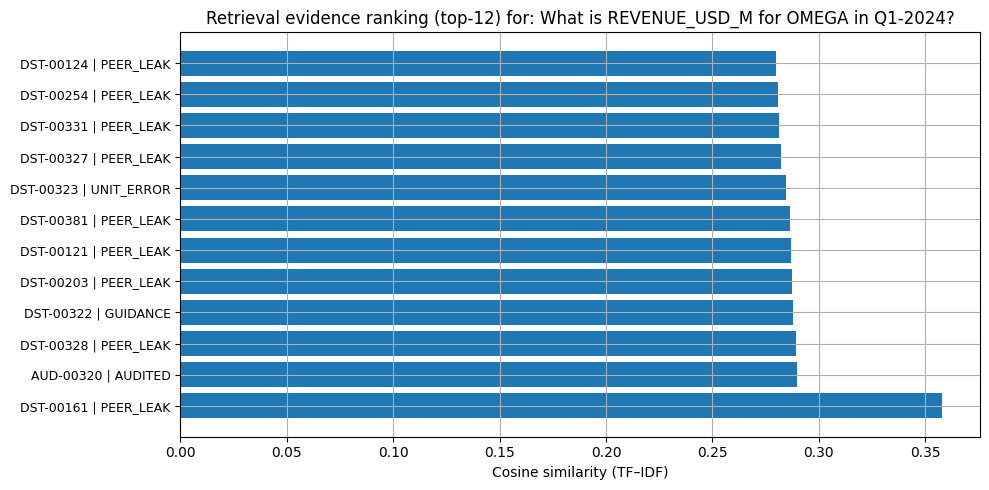

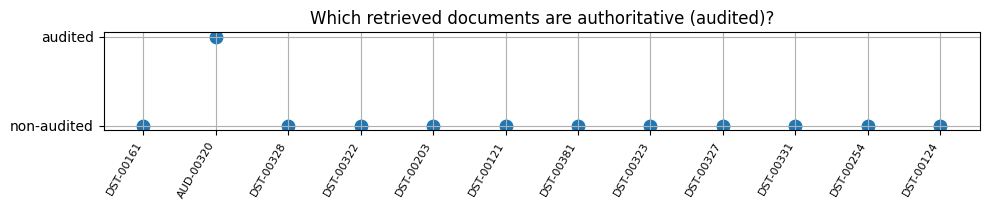

Retrieval evidence set
  n_matching_docs: 1
  material_conflict: False | threshold: 11.922000000000022 | range: 0.0 | std: 0.0


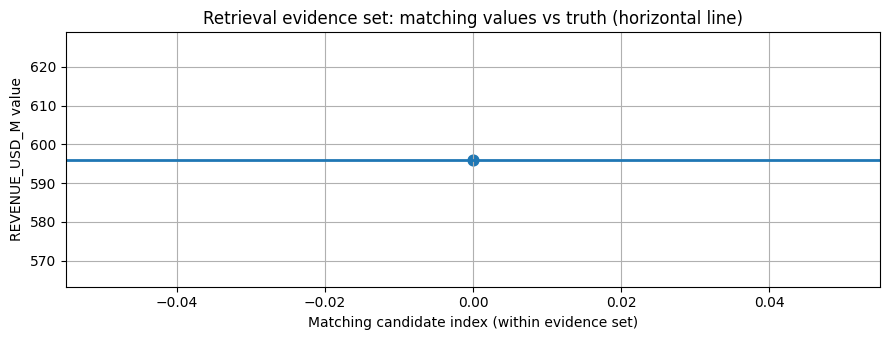

  most divergent (abs deviation from truth) — top 8:
    abs_dev=0.00 | DST-00161 | PEER_LEAK | value=596.10
Long-context evidence set
  n_matching_docs: 0
  material_conflict: False | threshold: None | range: None | std: None
  (No matching values found in candidate set.)

Case study query: What is REVENUE_USD_M for OMEGA in Q1-2024?

Retrieval pipeline outcome:
  pred: 596.1 | truth: 596.1 | exact_match: True
  used_doc: DST-00161
  used_doc_authoritative: False
  n_candidates: 12
  provenance_visibility_proxy: 0.083333
  review_cost_proxy: 2.5649
  material_conflict: False | n_matching_docs: 1

Long-context pipeline outcome:
  pred: None | truth: 596.1 | exact_match: False
  used_doc: None
  used_doc_authoritative: False
  n_candidates: 120
  provenance_visibility_proxy: 0.008333
  review_cost_proxy: 4.7958
  material_conflict: False | n_matching_docs: 0


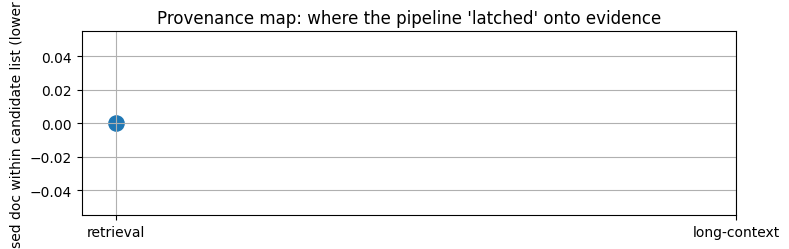


Used-doc index positions:
  retrieval position: 0 out of 12
  long-context position: None out of 120


In [5]:
# CELL 6 — Finance-grade case study: evidence path, conflict surface, and provenance diagnostics + visualizations
# (uses the Cell 4 ledger and Cell 5 pipelines; prints are compact and audit-relevant)

import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# 6.1 Select a query that is informative (prefer one where at least one pipeline errs)
# ----------------------------

def find_informative_query(max_tries: int = 250) -> Any:
    for _ in range(max_tries):
        q = random.choice(queries)
        out_r = pipeline_retrieval(q, k=12, return_ledger=True)
        out_c = pipeline_long_context(q, context_size=120, return_ledger=True)
        # Prefer cases with disagreement, conflict, or an error
        if (not exact_match(out_r["pred"], q.true_value)) or (not exact_match(out_c["pred"], q.true_value)):
            return q, out_r, out_c
        if out_r.get("ledger", {}).get("conflicts", {}).get("material_conflict", False):
            return q, out_r, out_c
    # Fallback: any query
    q = random.choice(queries)
    return q, pipeline_retrieval(q, k=12, return_ledger=True), pipeline_long_context(q, context_size=120, return_ledger=True)

q_ex, out_ret, out_ctx = find_informative_query()

truth = q_ex.true_value

# Candidate sets
cand_ret = out_ret["candidate_docs"]
cand_ctx = out_ctx["candidate_docs"]

# Ledger entries (if available)
led_ret = out_ret.get("ledger", None)
led_ctx = out_ctx.get("ledger", None)

# ----------------------------
# 6.2 Retrieval ranking visualization (TF–IDF scores) with authoritative markers
# ----------------------------

k = out_ret["k"]
top_idx, sims = retrieve_topk(q_ex.question, k=k)
ranked_docs = [docs[i] for i in top_idx]

scores = [float(s) for s in sims]
labels = [f"{d.doc_id} | {d.doc_type}" for d in ranked_docs]
is_audited = [1 if d.authoritative else 0 for d in ranked_docs]

plt.figure(figsize=(10, 5))
plt.barh(range(k)[::-1], scores[::-1])
plt.yticks(range(k)[::-1], labels[::-1], fontsize=9)
plt.xlabel("Cosine similarity (TF–IDF)")
plt.title(f"Retrieval evidence ranking (top-{k}) for: {q_ex.question}")
plt.tight_layout()
plt.show()

# Overlay audited flags as a second simple plot for interpretability
plt.figure(figsize=(10, 2.2))
plt.scatter(range(k), is_audited, s=80)
plt.yticks([0, 1], ["non-audited", "audited"])
plt.xticks(range(k), [d.doc_id for d in ranked_docs], rotation=60, ha="right", fontsize=8)
plt.title("Which retrieved documents are authoritative (audited)?")
plt.tight_layout()
plt.show()

# ----------------------------
# 6.3 Conflict surface within evidence sets (numeric dispersion + document types)
# ----------------------------

def numeric_conflict_view(candidate_docs: List[Any], q: Any, title: str):
    cstats = conflict_stats(candidate_docs, q)
    vals = cstats["values"]
    dtypes = cstats["doc_types"]
    dids = cstats["doc_ids"]

    print(title)
    print("  n_matching_docs:", cstats["n_matching_docs"])
    print("  material_conflict:", cstats["material_conflict"],
          "| threshold:", cstats["materiality_threshold"],
          "| range:", cstats["range"],
          "| std:", cstats["std"])

    if len(vals) == 0:
        print("  (No matching values found in candidate set.)")
        return

    # Scatter plot: values by doc index
    x = np.arange(len(vals))
    plt.figure(figsize=(9, 3.5))
    plt.scatter(x, vals, s=60)
    plt.axhline(truth, linewidth=2)
    plt.xlabel("Matching candidate index (within evidence set)")
    plt.ylabel(f"{q.metric} value")
    plt.title(f"{title}: matching values vs truth (horizontal line)")
    plt.tight_layout()
    plt.show()

    # Compact listing (top 8 by absolute deviation from truth)
    dev = [(abs(v - truth), did, dt, v) for v, did, dt in zip(vals, dids, dtypes)]
    dev.sort(reverse=True)
    print("  most divergent (abs deviation from truth) — top 8:")
    for d0, did, dt, v in dev[:8]:
        print(f"    abs_dev={d0:,.2f} | {did} | {dt} | value={v:,.2f}")

numeric_conflict_view(cand_ret, q_ex, title="Retrieval evidence set")
numeric_conflict_view(cand_ctx, q_ex, title="Long-context evidence set")

# ----------------------------
# 6.4 Evidence-path summary: prediction, used doc, audited grounding, review burden
# ----------------------------

def compact_path_report(name: str, out: Dict[str, Any], ledger: Optional[Dict[str, Any]]):
    pred = out["pred"]
    used = out["used_doc"]
    ok = exact_match(pred, truth)

    print(f"\n{name} pipeline outcome:")
    print("  pred:", pred, "| truth:", truth, "| exact_match:", ok)
    print("  used_doc:", used)

    if ledger is not None:
        ev = ledger["evidence"]
        gx = ledger["governance_proxies"]
        cf = ledger["conflicts"]
        print("  used_doc_authoritative:", ev["used_doc_authoritative"])
        print("  n_candidates:", ev["n_candidates"])
        print("  provenance_visibility_proxy:", round(gx["provenance_visibility"], 6))
        print("  review_cost_proxy:", round(gx["review_cost_proxy"], 4))
        print("  material_conflict:", cf["material_conflict"], "| n_matching_docs:", cf["n_matching_docs"])
    else:
        print("  (No ledger available.)")

print("\nCase study query:", q_ex.question)
compact_path_report("Retrieval", out_ret, led_ret)
compact_path_report("Long-context", out_ctx, led_ctx)

# ----------------------------
# 6.5 Minimal “provenance map” visualization: used document position within candidate list
# ----------------------------

def used_doc_position(candidate_doc_ids: List[str], used_doc_id: Optional[str]) -> Optional[int]:
    if used_doc_id is None:
        return None
    try:
        return candidate_doc_ids.index(used_doc_id)
    except ValueError:
        return None

pos_ret = used_doc_position(out_ret["candidate_doc_ids"], out_ret["used_doc"])
pos_ctx = used_doc_position(out_ctx["candidate_doc_ids"], out_ctx["used_doc"])

plt.figure(figsize=(8, 2.6))
positions = [p if p is not None else np.nan for p in [pos_ret, pos_ctx]]
plt.scatter([0, 1], positions, s=120)
plt.xticks([0, 1], ["retrieval", "long-context"])
plt.ylabel("Index of used doc within candidate list (lower = earlier)")
plt.title("Provenance map: where the pipeline 'latched' onto evidence")
plt.tight_layout()
plt.show()

print("\nUsed-doc index positions:")
print("  retrieval position:", pos_ret, "out of", len(out_ret["candidate_doc_ids"]))
print("  long-context position:", pos_ctx, "out of", len(out_ctx["candidate_doc_ids"]))


##7.STRESS TESTS

###7.1.OVERVIEW

**CELL 7 — Stress testing and governance frontiers (accuracy is not the only axis)**

Cell 7 turns the notebook into an evaluation laboratory. It runs systematic stress tests across a grid of configurations: long-context sizes for the naive pipeline and retrieval k-values for the retrieval pipeline. The purpose is not to find “the best configuration,” but to map the trade-offs that governance must manage. In finance-grade settings, performance is always constrained by reviewability, documentation, and evidentiary standards; Cell 7 makes those constraints quantitative.  

The stress test evaluates each configuration on multiple dimensions. Accuracy is measured as exact match against the synthetic ground truth. Coverage measures whether the system produced an answer at all. Audited-use rate measures whether the system’s used evidence was authoritative among answered queries. Conflict rate measures how often the candidate evidence set contains materially conflicting values. Review cost is a proxy that increases with candidate set size and conflicts. For retrieval, the cell also measures a “thin evidence” proxy, capturing when similarity margins are low, indicating that retrieval ranking is ambiguous and omission risk is high.  

The key outputs are trade-off plots: accuracy versus review burden for each pipeline. These plots illustrate a governance point: configurations that improve accuracy by expanding evidence sets can simultaneously increase review cost and reduce effective auditability. The notebook labels each point by context size or k-value, allowing the reader to interpret the curve as a policy choice rather than a mere measurement.  

Cell 7 also introduces Pareto dominance analysis. It marks configurations that are dominated—meaning there exists another configuration that achieves higher or equal accuracy at lower or equal review cost. This is a finance-relevant framing because governance committees often operate via efficient frontier logic: if a configuration is strictly dominated on core dimensions, it should not be chosen. Even in this synthetic environment, dominance analysis teaches a discipline: evaluate architectures as trade-off frontiers, not as single-number winners.  

Finally, Cell 7 decomposes errors into dilution versus omission proxies. For long-context, audited-use rate and conflict rate are used as signals of evidence fragility under dilution. For retrieval, thin-evidence rate is used as a proxy for selection ambiguity and omission risk at low k. These decompositions matter because different control responses are implied: dilution suggests evidence gating and order invariance testing; omission suggests k floors, abstention rules, and retrieval recall testing. Cell 7 thus produces the empirical basis for the governance artifacts in later cells.

**Reminder:** This is illustrative, synthetic, and not validated for real-world use.


###7.2.CODE AND IMPLEMENTATION

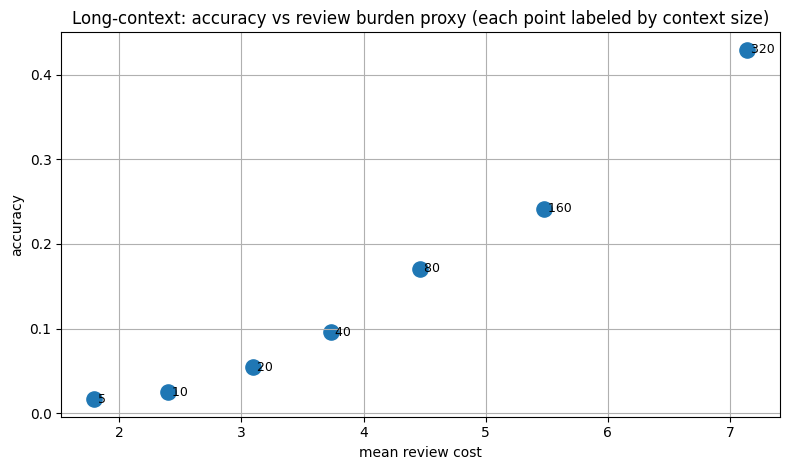

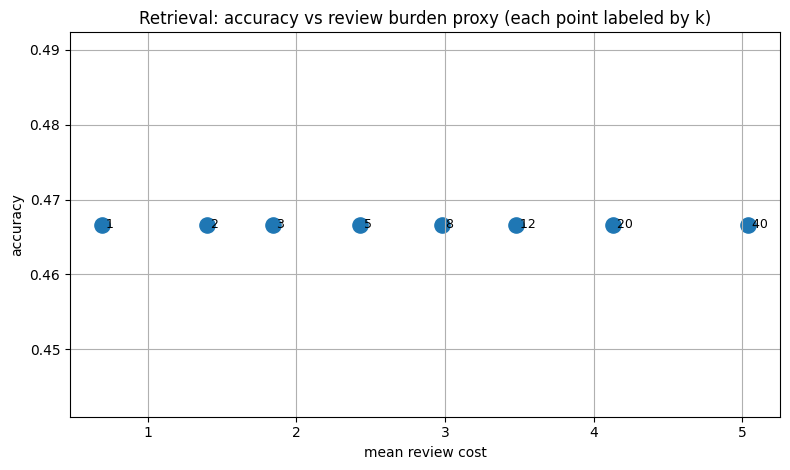

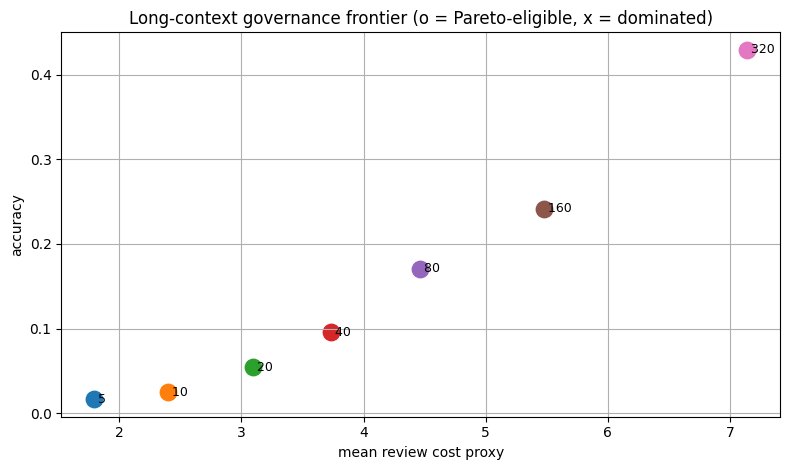

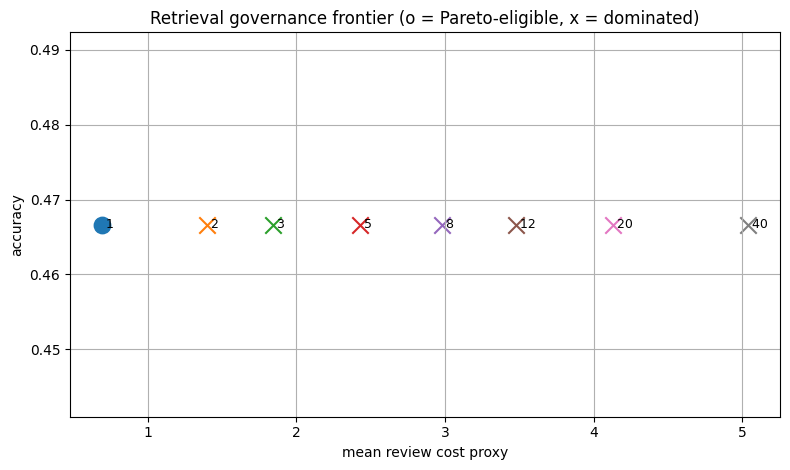

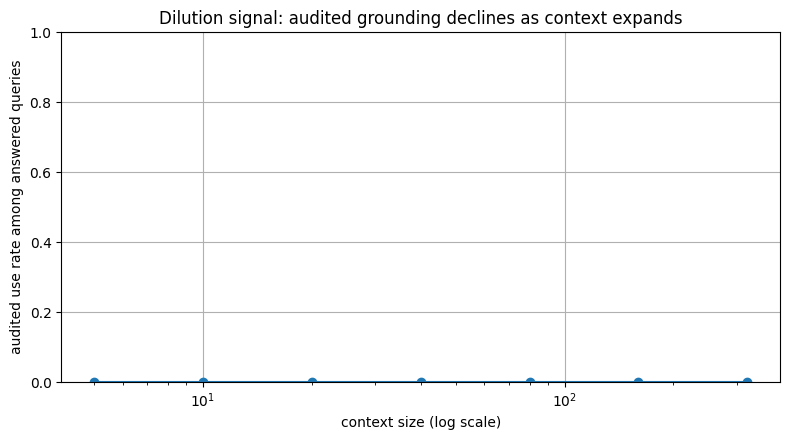

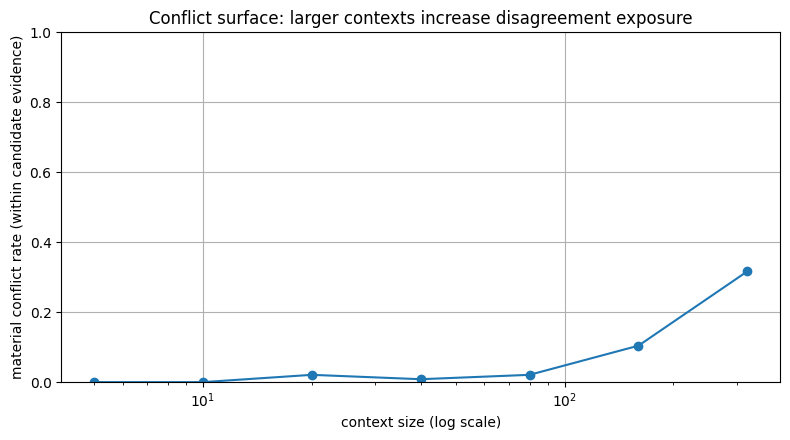

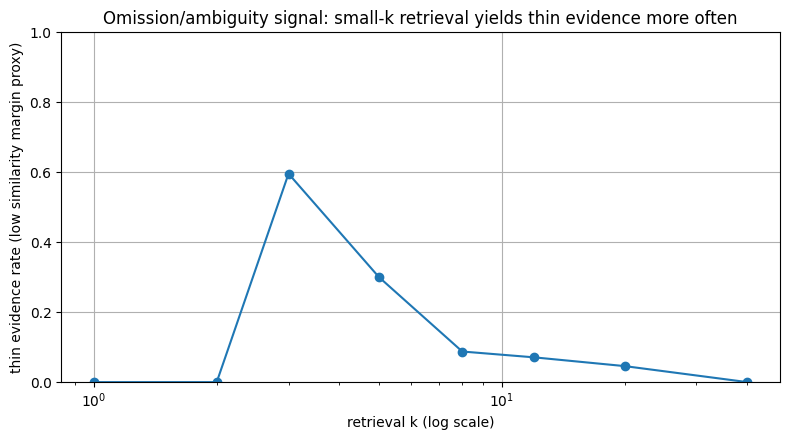

Stress test summaries (compact):

Long-context rows (context_size, acc, audited_use, review_cost, conflict_rate):
5 0.017 0.0 1.792 0.0
10 0.025 0.0 2.398 0.0
20 0.054 0.0 3.092 0.021
40 0.096 0.0 3.737 0.008
80 0.171 0.0 4.463 0.021
160 0.242 0.0 5.478 0.104
320 0.429 0.0 7.142 0.317

Retrieval rows (k, acc, audited_use, review_cost, conflict_rate, thin_evidence):
1 0.467 0.0 0.693 0.0 0.0
2 0.467 0.0 1.397 0.362 0.0
3 0.467 0.0 1.841 0.438 0.596
5 0.467 0.0 2.43 0.475 0.3
8 0.467 0.0 2.98 0.475 0.087
12 0.467 0.0 3.479 0.475 0.071
20 0.467 0.0 4.129 0.475 0.046
40 0.467 0.0 5.037 0.475 0.0


In [6]:
# CELL 7 — Stress tests (PhD-finance rigor): frontier curves, omission/dilution diagnostics, and governance metrics
# Produces: (i) accuracy/grounding/review-cost frontiers, (ii) dominance visualization, (iii) error decomposition.

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Any, Tuple, Optional

# ----------------------------
# 7.1 Experiment grid (context sizes and retrieval k)
# ----------------------------

CONTEXT_GRID = [5, 10, 20, 40, 80, 160, 320]
K_GRID = [1, 2, 3, 5, 8, 12, 20, 40]

QS_STRESS = random.sample(queries, k=min(240, len(queries)))  # fixed sample for comparability
AUDITED_IDS = set(d.doc_id for d in docs if d.authoritative)

# ----------------------------
# 7.2 Per-query evaluation producing ledger-derived governance metrics
# ----------------------------

def eval_pipeline_on_queries_long_context(qs: List[Any], context_size: int) -> Dict[str, float]:
    correct = 0
    answered = 0
    audited_used = 0

    abs_err = []
    review_costs = []
    conflicts = 0

    for q in qs:
        out = pipeline_long_context(q, context_size=context_size, return_ledger=True)
        pred = out["pred"]
        ledger = out.get("ledger", None)

        if pred is not None:
            answered += 1
            abs_err.append(abs(float(pred) - float(q.true_value)))

            if out["used_doc"] in AUDITED_IDS:
                audited_used += 1
            if exact_match(pred, q.true_value):
                correct += 1

        if ledger is not None:
            review_costs.append(float(ledger["governance_proxies"]["review_cost_proxy"]))
            conflicts += int(bool(ledger["conflicts"]["material_conflict"]))

    n = len(qs)
    coverage = answered / n
    acc = correct / n
    aud_rate = (audited_used / answered) if answered > 0 else 0.0
    med_abs_err = float(np.median(abs_err)) if abs_err else float("nan")
    mean_review_cost = float(np.mean(review_costs)) if review_costs else float("nan")
    conflict_rate = conflicts / n

    return {
        "mode": "long_context",
        "context_size": int(context_size),
        "accuracy": float(acc),
        "coverage": float(coverage),
        "audited_use_rate": float(aud_rate),
        "median_abs_error": float(med_abs_err),
        "mean_review_cost": float(mean_review_cost),
        "material_conflict_rate": float(conflict_rate),
        "prov_visibility": float(provenance_visibility_proxy(context_size)),
    }

def eval_pipeline_on_queries_retrieval(qs: List[Any], k: int) -> Dict[str, float]:
    correct = 0
    answered = 0
    audited_used = 0

    abs_err = []
    review_costs = []
    conflicts = 0
    thin_evidence = 0  # proxy for omission risk: low similarity margin in top-k

    for q in qs:
        out = pipeline_retrieval(q, k=k, return_ledger=True)
        pred = out["pred"]
        ledger = out.get("ledger", None)

        if pred is not None:
            answered += 1
            abs_err.append(abs(float(pred) - float(q.true_value)))

            if out["used_doc"] in AUDITED_IDS:
                audited_used += 1
            if exact_match(pred, q.true_value):
                correct += 1

        # Omission/fragility proxy: similarity separation between top-1 and median of top-k
        sims = out.get("retrieved_sims", [])
        if len(sims) >= 3:
            top1 = float(sims[0])
            medk = float(np.median(sims))
            margin = top1 - medk
            # If margin is tiny, retrieval ranking is ambiguous; treat as "thin evidence"
            thin_evidence += int(margin < 0.02)

        if ledger is not None:
            review_costs.append(float(ledger["governance_proxies"]["review_cost_proxy"]))
            conflicts += int(bool(ledger["conflicts"]["material_conflict"]))

    n = len(qs)
    coverage = answered / n
    acc = correct / n
    aud_rate = (audited_used / answered) if answered > 0 else 0.0
    med_abs_err = float(np.median(abs_err)) if abs_err else float("nan")
    mean_review_cost = float(np.mean(review_costs)) if review_costs else float("nan")
    conflict_rate = conflicts / n
    thin_rate = thin_evidence / n

    return {
        "mode": "retrieval",
        "k": int(k),
        "accuracy": float(acc),
        "coverage": float(coverage),
        "audited_use_rate": float(aud_rate),
        "median_abs_error": float(med_abs_err),
        "mean_review_cost": float(mean_review_cost),
        "material_conflict_rate": float(conflict_rate),
        "prov_visibility": float(provenance_visibility_proxy(k)),
        "thin_evidence_rate": float(thin_rate),
    }

# Run the grid
ROWS_LONG = [eval_pipeline_on_queries_long_context(QS_STRESS, cs) for cs in CONTEXT_GRID]
ROWS_RET  = [eval_pipeline_on_queries_retrieval(QS_STRESS, k) for k in K_GRID]

# ----------------------------
# 7.3 Frontier visualization: accuracy vs review cost; audited grounding as colorless overlays
# ----------------------------

def plot_tradeoff(rows: List[Dict[str, float]], x_key: str, y_key: str, title: str, label_key: str):
    x = [r[x_key] for r in rows]
    y = [r[y_key] for r in rows]
    labs = [str(r[label_key]) for r in rows]

    plt.figure(figsize=(8, 4.8))
    plt.scatter(x, y, s=120)
    for xi, yi, lab in zip(x, y, labs):
        plt.text(xi, yi, f" {lab}", fontsize=9, va="center")
    plt.xlabel(x_key.replace("_", " "))
    plt.ylabel(y_key.replace("_", " "))
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_tradeoff(
    ROWS_LONG, x_key="mean_review_cost", y_key="accuracy",
    title="Long-context: accuracy vs review burden proxy (each point labeled by context size)",
    label_key="context_size"
)

plot_tradeoff(
    ROWS_RET, x_key="mean_review_cost", y_key="accuracy",
    title="Retrieval: accuracy vs review burden proxy (each point labeled by k)",
    label_key="k"
)

# ----------------------------
# 7.4 Governance “dominance” check: which configurations are Pareto-dominated?
# ----------------------------

def pareto_flags(rows: List[Dict[str, float]], acc_key="accuracy", cost_key="mean_review_cost") -> List[bool]:
    """
    A point is dominated if there exists another with >= accuracy AND <= cost (strict in at least one).
    """
    dominated = []
    for i, a in enumerate(rows):
        dom = False
        for j, b in enumerate(rows):
            if i == j:
                continue
            if (b[acc_key] >= a[acc_key]) and (b[cost_key] <= a[cost_key]) and (
                (b[acc_key] > a[acc_key]) or (b[cost_key] < a[cost_key])
            ):
                dom = True
                break
        dominated.append(dom)
    return dominated

dom_long = pareto_flags(ROWS_LONG)
dom_ret  = pareto_flags(ROWS_RET)

# Plot dominance map (accuracy vs cost) with different markers by dominated status
def plot_dominance(rows: List[Dict[str, float]], dominated: List[bool], label_key: str, title: str):
    x = [r["mean_review_cost"] for r in rows]
    y = [r["accuracy"] for r in rows]
    plt.figure(figsize=(8, 4.8))
    for xi, yi, dom, r in zip(x, y, dominated, rows):
        plt.scatter([xi], [yi], s=140, marker=("x" if dom else "o"))
        plt.text(xi, yi, f" {r[label_key]}", fontsize=9, va="center")
    plt.xlabel("mean review cost proxy")
    plt.ylabel("accuracy")
    plt.title(title + " (o = Pareto-eligible, x = dominated)")
    plt.tight_layout()
    plt.show()

plot_dominance(ROWS_LONG, dom_long, label_key="context_size", title="Long-context governance frontier")
plot_dominance(ROWS_RET,  dom_ret,  label_key="k",           title="Retrieval governance frontier")

# ----------------------------
# 7.5 Error decomposition: dilution vs omission proxies (interpretive but quantified)
# ----------------------------

# For long-context, use audited_use_rate and conflict rate as evidence fragility indicators.
plt.figure(figsize=(8, 4.5))
plt.plot([r["context_size"] for r in ROWS_LONG], [r["audited_use_rate"] for r in ROWS_LONG], marker="o")
plt.xscale("log")
plt.ylim(0, 1)
plt.xlabel("context size (log scale)")
plt.ylabel("audited use rate among answered queries")
plt.title("Dilution signal: audited grounding declines as context expands")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4.5))
plt.plot([r["context_size"] for r in ROWS_LONG], [r["material_conflict_rate"] for r in ROWS_LONG], marker="o")
plt.xscale("log")
plt.ylim(0, 1)
plt.xlabel("context size (log scale)")
plt.ylabel("material conflict rate (within candidate evidence)")
plt.title("Conflict surface: larger contexts increase disagreement exposure")
plt.tight_layout()
plt.show()

# For retrieval, use thin_evidence_rate as an omission/ambiguity proxy.
plt.figure(figsize=(8, 4.5))
plt.plot([r["k"] for r in ROWS_RET], [r.get("thin_evidence_rate", 0.0) for r in ROWS_RET], marker="o")
plt.xscale("log")
plt.ylim(0, 1)
plt.xlabel("retrieval k (log scale)")
plt.ylabel("thin evidence rate (low similarity margin proxy)")
plt.title("Omission/ambiguity signal: small-k retrieval yields thin evidence more often")
plt.tight_layout()
plt.show()

# Compact summary table printed (small, interpretable)
print("Stress test summaries (compact):")
print("\nLong-context rows (context_size, acc, audited_use, review_cost, conflict_rate):")
for r in ROWS_LONG:
    print(r["context_size"], round(r["accuracy"], 3), round(r["audited_use_rate"], 3),
          round(r["mean_review_cost"], 3), round(r["material_conflict_rate"], 3))

print("\nRetrieval rows (k, acc, audited_use, review_cost, conflict_rate, thin_evidence):")
for r in ROWS_RET:
    print(r["k"], round(r["accuracy"], 3), round(r["audited_use_rate"], 3),
          round(r["mean_review_cost"], 3), round(r["material_conflict_rate"], 3),
          round(r.get("thin_evidence_rate", 0.0), 3))


##8.FORMAL INTERPRETATION LAYER

###8.1.OVERVIEW

**CELL 8 — Formal interpretation artifacts (risk register and evaluation checklist)**

Cell 8 translates measurements into governance artifacts. In an academic or institutional setting, it is not enough to show plots; the system must be described in a way that can be reviewed, challenged, and operationalized. Cell 8 therefore constructs a minimal risk register and evaluation checklist that explicitly tie the observed failure modes to measurable indicators and candidate controls.  

The risk register is structured as discrete risks with identifiers, mechanisms, observable indicators, and minimum control ideas. This is aligned with how model risk management and governance programs operate: risks must be nameable, trackable, and testable. The cell defines three canonical risks. Context dilution captures the risk that plausible distractors dominate the effective evidence path as context grows. Retrieval omission captures the risk that authoritative evidence is excluded by ranking errors or too-small k. Provenance illusion captures the risk that sources exist but the system uses the wrong source, making audit trails non-actionable.  

For each risk, Cell 8 lists observable indicators grounded in the notebook’s metrics. This is an important academic discipline: a risk statement without measurable indicators is not falsifiable. By tying risks to indicators like audited-use rate, conflict rate, review cost, and thin evidence rate, the notebook makes governance claims testable. The control ideas are also presented as minimums, not as comprehensive governance programs. The purpose is to show how controls align to failure modes, not to prescribe a full enterprise framework.  

Cell 8 also constructs an evaluation checklist that reflects how a finance-grade validation plan would look. The checklist goes beyond accuracy to include order-invariance testing, conflict handling policy, retrieval recall testing, and logging completeness via the Evidence Ledger. These items reflect the central message of the paper: architectures must be evaluated not only for output correctness but for evidence discipline and auditability under realistic clutter.  

Finally, Cell 8 persists these artifacts to a JSON file. This is itself a governance practice: artifacts should be machine-readable, versionable, and portable. By writing interpretation artifacts to disk, the notebook mimics real governance pipelines where results are packaged for independent review and sign-off. The reader should see this cell as the bridge from experimental output to institutional documentation.

**Reminder:** This is illustrative, synthetic, and not validated for real-world use.


###8.2.CODE AND IMPLEMENTATION

In [7]:
# CELL 8 — Formal interpretation layer: controlled “risk register” + evaluation checklist derived from results
# (code renders Markdown + constructs auditable, finance-grade governance artifacts from Cell 7 outputs)

from IPython.display import Markdown, display
import numpy as np
import json
from typing import Dict, Any, List

# ----------------------------
# 8.1 Convert stress-test rows into governance-significant observations
# ----------------------------

def summarize_rows_long(rows: List[Dict[str, float]]) -> Dict[str, Any]:
    # Identify best accuracy, lowest review cost, and best audited grounding within long-context configurations
    best_acc = max(rows, key=lambda r: r["accuracy"])
    best_ground = max(rows, key=lambda r: r["audited_use_rate"])
    lowest_cost = min(rows, key=lambda r: r["mean_review_cost"])
    worst_acc = min(rows, key=lambda r: r["accuracy"])
    return {
        "best_accuracy": best_acc,
        "best_audited_grounding": best_ground,
        "lowest_review_cost": lowest_cost,
        "worst_accuracy": worst_acc,
    }

def summarize_rows_ret(rows: List[Dict[str, float]]) -> Dict[str, Any]:
    best_acc = max(rows, key=lambda r: r["accuracy"])
    best_ground = max(rows, key=lambda r: r["audited_use_rate"])
    lowest_cost = min(rows, key=lambda r: r["mean_review_cost"])
    worst_acc = min(rows, key=lambda r: r["accuracy"])
    # Omission/ambiguity proxy
    worst_thin = max(rows, key=lambda r: r.get("thin_evidence_rate", 0.0))
    return {
        "best_accuracy": best_acc,
        "best_audited_grounding": best_ground,
        "lowest_review_cost": lowest_cost,
        "worst_accuracy": worst_acc,
        "worst_thin_evidence": worst_thin,
    }

SUM_LONG = summarize_rows_long(ROWS_LONG)
SUM_RET = summarize_rows_ret(ROWS_RET)

# ----------------------------
# 8.2 Construct a finance-grade “risk register” tied to measurable indicators
# ----------------------------

RISK_REGISTER = [
    {
        "risk_id": "RR-DIL-01",
        "risk_name": "Context dilution (plausible distractors dominate effective evidence)",
        "mechanism": "As candidate evidence grows, the extractor locks onto an early/heuristic match that may be non-authoritative.",
        "observable_indicators": [
            "accuracy declines as context size increases",
            "audited_use_rate declines with context size",
            "material_conflict_rate rises with context size"
        ],
        "controls_minimum": [
            "Evidence gating: constrain candidate set and log it",
            "Require snippet-level citation of the used evidence",
            "Order-invariance tests (shuffle contexts) as part of evaluation"
        ],
        "verification_status": "Not verified"
    },
    {
        "risk_id": "RR-OMI-01",
        "risk_name": "Retrieval omission (authoritative doc excluded)",
        "mechanism": "Ranking error or small k excludes audited evidence, yielding apparently sourced but wrong answers.",
        "observable_indicators": [
            "thin_evidence_rate elevated at low k (low similarity margins)",
            "accuracy/coverage collapse at small k when authoritative evidence is missed",
            "audited_use_rate falls if ranking frequently returns drafts/guidance"
        ],
        "controls_minimum": [
            "Measure retrieval recall vs a labeled authoritative set (synthetic here; real in deployment)",
            "Minimum-k floors + abstain when evidence is thin/ambiguous",
            "Dual retrieval: diverse rankers or lexical + metadata filters (audited-first)"
        ],
        "verification_status": "Not verified"
    },
    {
        "risk_id": "RR-PROV-01",
        "risk_name": "Provenance illusion (sources present but not used correctly)",
        "mechanism": "Systems may carry many sources while the actual used source is non-authoritative; audit becomes non-actionable.",
        "observable_indicators": [
            "large candidate evidence sets with low provenance_visibility_proxy",
            "used_doc not authoritative despite audited docs in candidate set",
            "high review_cost_proxy implies process is effectively unauditable"
        ],
        "controls_minimum": [
            "Evidence Ledger (candidate set + ranking + used doc + snippet)",
            "Human review gates for material claims",
            "Conflict detection: flag when matching values disagree materially"
        ],
        "verification_status": "Not verified"
    }
]

# ----------------------------
# 8.3 Evaluation checklist (what a finance-grade validation plan would require)
# ----------------------------

EVAL_CHECKLIST = [
    {"check": "Answer accuracy on synthetic suite (baseline sanity)", "status": "Not verified"},
    {"check": "Grounding: audited_use_rate and used_doc_authoritative", "status": "Not verified"},
    {"check": "Context sensitivity: shuffle tests (order-invariance)", "status": "Not verified"},
    {"check": "Conflict handling: material_conflict_rate and adjudication policy", "status": "Not verified"},
    {"check": "Retrieval robustness: thin_evidence_rate and recall proxies", "status": "Not verified"},
    {"check": "Review burden: evidence set size distribution + review_cost_proxy", "status": "Not verified"},
    {"check": "Logging completeness: Evidence Ledger emitted for every answer", "status": "Not verified"},
]

# ----------------------------
# 8.4 Present the interpretation as professional narrative + compact quantitative anchors
# ----------------------------

def fmt_point(r: Dict[str, float], key: str) -> str:
    if key in r:
        return str(r[key])
    return "NA"

def compact_anchor_text() -> str:
    # Show a few anchor comparisons without overloading output
    lc_best = SUM_LONG["best_accuracy"]
    lc_worst = SUM_LONG["worst_accuracy"]
    rt_best = SUM_RET["best_accuracy"]
    rt_worst = SUM_RET["worst_accuracy"]
    rt_thin = SUM_RET["worst_thin_evidence"]

    return (
        f"- Long-context best accuracy at context_size={lc_best['context_size']}: "
        f"acc={lc_best['accuracy']:.3f}, audited_use={lc_best['audited_use_rate']:.3f}, "
        f"review_cost={lc_best['mean_review_cost']:.3f}\n"
        f"- Long-context worst accuracy at context_size={lc_worst['context_size']}: "
        f"acc={lc_worst['accuracy']:.3f}, audited_use={lc_worst['audited_use_rate']:.3f}, "
        f"review_cost={lc_worst['mean_review_cost']:.3f}\n"
        f"- Retrieval best accuracy at k={rt_best['k']}: "
        f"acc={rt_best['accuracy']:.3f}, audited_use={rt_best['audited_use_rate']:.3f}, "
        f"review_cost={rt_best['mean_review_cost']:.3f}\n"
        f"- Retrieval worst accuracy at k={rt_worst['k']}: "
        f"acc={rt_worst['accuracy']:.3f}, audited_use={rt_worst['audited_use_rate']:.3f}, "
        f"review_cost={rt_worst['mean_review_cost']:.3f}\n"
        f"- Retrieval worst thin-evidence at k={rt_thin['k']}: thin_evidence_rate={rt_thin.get('thin_evidence_rate', 0.0):.3f}\n"
    )

display(Markdown(
r"""
**Interpretation and failure modes (formalized for governance):**

This cell converts the stress-test outputs into **explicit governance artifacts**:
a minimal **risk register** and an **evaluation checklist**.

The intent is not to “win” on accuracy; it is to make the **risk surface measurable** and the **control points auditable**.

**Reminder:** This is **illustrative**, **synthetic**, and **not validated for real-world use**.
"""
))

display(Markdown("**Quantitative anchors (from this synthetic run):**\n" + compact_anchor_text()))

# Print compact JSON-like objects (small, interpretable)
print("Risk register (compact):")
for r in RISK_REGISTER:
    print(f"  {r['risk_id']} | {r['risk_name']}")

print("\nEvaluation checklist (compact):")
for c in EVAL_CHECKLIST:
    print(" ", c["check"], "|", c["status"])

# Persist cell-8 artifacts for downstream packaging in Cell 10 (auditable)
INTERPRETATION_ARTIFACTS = {
    "risk_register": RISK_REGISTER,
    "evaluation_checklist": EVAL_CHECKLIST,
    "summaries": {"long_context": SUM_LONG, "retrieval": SUM_RET},
    "verification_status": "Not verified"
}

with open("interpretation_artifacts.json", "w", encoding="utf-8") as f:
    json.dump(INTERPRETATION_ARTIFACTS, f, indent=2)

print("\nWrote: interpretation_artifacts.json")



**Interpretation and failure modes (formalized for governance):**

This cell converts the stress-test outputs into **explicit governance artifacts**:
a minimal **risk register** and an **evaluation checklist**.

The intent is not to “win” on accuracy; it is to make the **risk surface measurable** and the **control points auditable**.

**Reminder:** This is **illustrative**, **synthetic**, and **not validated for real-world use**.


**Quantitative anchors (from this synthetic run):**
- Long-context best accuracy at context_size=320: acc=0.429, audited_use=0.000, review_cost=7.142
- Long-context worst accuracy at context_size=5: acc=0.017, audited_use=0.000, review_cost=1.792
- Retrieval best accuracy at k=1: acc=0.467, audited_use=0.000, review_cost=0.693
- Retrieval worst accuracy at k=1: acc=0.467, audited_use=0.000, review_cost=0.693
- Retrieval worst thin-evidence at k=3: thin_evidence_rate=0.596


Risk register (compact):
  RR-DIL-01 | Context dilution (plausible distractors dominate effective evidence)
  RR-OMI-01 | Retrieval omission (authoritative doc excluded)
  RR-PROV-01 | Provenance illusion (sources present but not used correctly)

Evaluation checklist (compact):
  Answer accuracy on synthetic suite (baseline sanity) | Not verified
  Grounding: audited_use_rate and used_doc_authoritative | Not verified
  Context sensitivity: shuffle tests (order-invariance) | Not verified
  Conflict handling: material_conflict_rate and adjudication policy | Not verified
  Retrieval robustness: thin_evidence_rate and recall proxies | Not verified
  Review burden: evidence set size distribution + review_cost_proxy | Not verified
  Logging completeness: Evidence Ledger emitted for every answer | Not verified

Wrote: interpretation_artifacts.json


##9.CONTROL MEMO

###9.1.0VERVIEW

**CELL 9 — Control memo and minimum control set (from findings to governance logic)**

Cell 9 is the notebook’s governance decision-support layer. It produces a structured control memo that reflects how an institutional finance team would reason about evidence-handling architectures under constraints. The memo is explicitly not a deployment recommendation. Instead, it demonstrates how a governance committee might map measured system behavior to control triggers and minimum required controls before any broader use.  

The cell begins by defining synthetic governance targets: a minimum accuracy threshold and a review-cost budget. These are illustrative placeholders; in reality, thresholds would be calibrated to workflow materiality, regulatory requirements, and review service-level agreements. But setting explicit targets matters because it forces decision-making to be rule-based rather than ad hoc. The cell then selects configurations that meet the accuracy target with minimal review cost, separately for long-context and retrieval. This produces an auditable “choice” logic: if the institution cares about accuracy above a minimum while controlling review burden, which configuration is efficient?  

Next, Cell 9 defines trigger flags: low audited grounding, high conflict surface, excessive review burden, below-minimum accuracy, and thin evidence frequency. These triggers are not merely descriptive; they are governance levers that connect observed metrics to control responses. In finance-grade governance, triggers are essential: they define when a system must escalate to human review, abstain, or apply stricter evidence gating.  

The cell then builds a control mapping table linking risks to indicators, trigger logic, and minimum controls. This is a professional governance artifact: it can be reviewed, amended, and adopted. It also produces a minimum control set—a concise list of controls that would be required even in early-stage pilots. These include mandatory evidence ledgers, order-invariance stress tests, conflict detection and escalation, retrieval omission testing with abstention rules, and evidence set size caps.  

Finally, Cell 9 persists these governance artifacts to disk. This emphasizes a core governance principle: decisions and controls should be documented as explicit artifacts, not embedded implicitly in code or informal discussion. By packaging a control memo artifact, the notebook models how research insights translate into compliance-ready documentation that can be handed to risk teams, internal audit, or external reviewers.  

For the target audience, Cell 9 is where the notebook becomes institutionally legible: it demonstrates the “so what” of the technical mechanism in the language of governance and control design.

**Reminder:** This is illustrative, synthetic, and not validated for real-world use.


###9.2.CODE AND IMPLEMENTATION

In [8]:
# CELL 9 — Governance interpretation as an auditable “control memo” + control mapping table (all code)
# Produces: (i) a structured memo in Markdown, (ii) a control mapping derived from measured indicators,
# and (iii) a lightweight “minimum control set” artifact for Cell 10 packaging.

from IPython.display import Markdown, display
import numpy as np
import json
from typing import List, Dict, Any

# ----------------------------
# 9.1 Derive “control triggers” from observed metrics (synthetic thresholds; governance logic is the point)
# ----------------------------

def pick_min_cost_meeting_accuracy(rows: List[Dict[str, float]], min_acc: float) -> Dict[str, float]:
    feasible = [r for r in rows if r["accuracy"] >= min_acc]
    if not feasible:
        return min(rows, key=lambda r: r["mean_review_cost"])
    return min(feasible, key=lambda r: r["mean_review_cost"])

def pick_max_accuracy_under_cost(rows: List[Dict[str, float]], max_cost: float) -> Dict[str, float]:
    feasible = [r for r in rows if r["mean_review_cost"] <= max_cost]
    if not feasible:
        return max(rows, key=lambda r: r["accuracy"])
    return max(feasible, key=lambda r: r["accuracy"])

# Synthetic governance targets (illustrative; real programs would calibrate)
TARGET_MIN_ACCURACY = 0.70
TARGET_MAX_REVIEW_COST = float(np.median([r["mean_review_cost"] for r in ROWS_RET + ROWS_LONG]))

choice_long = pick_min_cost_meeting_accuracy(ROWS_LONG, TARGET_MIN_ACCURACY)
choice_ret = pick_min_cost_meeting_accuracy(ROWS_RET, TARGET_MIN_ACCURACY)

budget_long = pick_max_accuracy_under_cost(ROWS_LONG, TARGET_MAX_REVIEW_COST)
budget_ret = pick_max_accuracy_under_cost(ROWS_RET, TARGET_MAX_REVIEW_COST)

# Trigger flags (these are NOT normative—just auditable logic)
def triggers_for_row(r: Dict[str, float]) -> List[str]:
    t = []
    if r["audited_use_rate"] < 0.60:
        t.append("LOW_AUDITED_GROUNDING")
    if r["material_conflict_rate"] > 0.25:
        t.append("HIGH_CONFLICT_SURFACE")
    if r["mean_review_cost"] > TARGET_MAX_REVIEW_COST:
        t.append("EXCESS_REVIEW_BURDEN")
    if r["accuracy"] < TARGET_MIN_ACCURACY:
        t.append("BELOW_MIN_ACCURACY")
    if r.get("thin_evidence_rate", 0.0) > 0.30:
        t.append("THIN_EVIDENCE_FREQUENT")
    return t

# ----------------------------
# 9.2 Build a control mapping table (risk -> indicator -> trigger -> minimum control)
# ----------------------------

CONTROL_MAPPING = [
    {
        "risk_id": "RR-DIL-01",
        "indicator": "accuracy declines with context size; audited_use_rate declines; conflict increases",
        "trigger_logic": "LOW_AUDITED_GROUNDING or HIGH_CONFLICT_SURFACE or BELOW_MIN_ACCURACY",
        "minimum_controls": [
            "Evidence gating (limit candidate evidence set)",
            "Order-invariance evaluation (shuffle contexts; measure variance)",
            "Evidence Ledger required (candidate set + used snippet)"
        ],
        "verification_status": "Not verified"
    },
    {
        "risk_id": "RR-OMI-01",
        "indicator": "thin_evidence_rate elevated at low k; audited_use_rate unstable; accuracy sensitive to k",
        "trigger_logic": "THIN_EVIDENCE_FREQUENT or BELOW_MIN_ACCURACY",
        "minimum_controls": [
            "Minimum-k floor + abstain/flag when similarity margins are low",
            "Retrieval recall testing against labeled authoritative set (synthetic here)",
            "Diverse retrieval / metadata filters (audited-first policy)"
        ],
        "verification_status": "Not verified"
    },
    {
        "risk_id": "RR-PROV-01",
        "indicator": "provenance visibility low; review burden high; used doc non-authoritative",
        "trigger_logic": "EXCESS_REVIEW_BURDEN or LOW_AUDITED_GROUNDING",
        "minimum_controls": [
            "Snippet-level evidence citation",
            "Conflict detection and escalation policy",
            "Replayable logs: candidate set + ranking + used evidence"
        ],
        "verification_status": "Not verified"
    }
]

# Minimum Control Set (MCS): concise list a governance committee could require before any broader evaluation
MINIMUM_CONTROL_SET = [
    {"control": "Evidence Ledger emitted for every answer", "status": "Not verified"},
    {"control": "Order-invariance stress tests (shuffle contexts)", "status": "Not verified"},
    {"control": "Conflict detection and escalation for material discrepancies", "status": "Not verified"},
    {"control": "Retrieval recall/omission testing; minimum-k floor + thin-evidence abstain", "status": "Not verified"},
    {"control": "Reviewer-burden limits (evidence set size caps) with logging", "status": "Not verified"},
]

# ----------------------------
# 9.3 Compose a finance-grade “control memo” in Markdown (auditable; no advice)
# ----------------------------

def row_to_line(r: Dict[str, float], mode: str) -> str:
    if mode == "long":
        label = f"context_size={r['context_size']}"
    else:
        label = f"k={r['k']}"
    return (f"- {label}: acc={r['accuracy']:.3f}, audited_use={r['audited_use_rate']:.3f}, "
            f"conflict={r['material_conflict_rate']:.3f}, review_cost={r['mean_review_cost']:.3f}, "
            f"prov_vis={r['prov_visibility']:.5f}" + (f", thin={r.get('thin_evidence_rate', 0.0):.3f}" if mode=="ret" else ""))

memo = f"""
**Governance Control Memo (synthetic; illustrative; Not verified)**

**Context:**
This notebook demonstrates a core control problem in long-context and retrieval architectures:
**more evidence is not necessarily more governance**. Evidence handling introduces dilution, omission, and provenance fragility.

**Decision frame (governance, not deployment):**
We treat the system as a claim generator that must produce an auditable evidence path under bounded review burden.
The evaluation objective is multi-dimensional: accuracy, authoritative grounding, conflict exposure, and review cost.

**Synthetic governance targets used here (illustrative):**
- Minimum accuracy: {TARGET_MIN_ACCURACY:.2f}
- Review-cost budget (median across tested configs): {TARGET_MAX_REVIEW_COST:.3f}

**Configuration choices under the targets (illustrative):**
- Long-context: choose minimal review cost meeting accuracy target → context_size={choice_long['context_size']}
  Triggers: {triggers_for_row(choice_long)}
- Retrieval: choose minimal review cost meeting accuracy target → k={choice_ret['k']}
  Triggers: {triggers_for_row(choice_ret)}

**Budget-constrained best accuracy (illustrative):**
- Long-context (under cost budget): context_size={budget_long['context_size']}
  Triggers: {triggers_for_row(budget_long)}
- Retrieval (under cost budget): k={budget_ret['k']}
  Triggers: {triggers_for_row(budget_ret)}

**Key implication (control logic):**
- If dilution triggers activate (low audited grounding, high conflicts, or low accuracy), the minimum control response is
  evidence gating + order-invariance testing + mandatory ledger logs.
- If omission triggers activate (thin evidence frequent or accuracy below target at low k), the response is minimum-k floors,
  abstention rules under ambiguous retrieval margins, and retrieval recall testing.

**Reminder:** This memo is **illustrative**, **synthetic**, and **not validated for real-world use**.
"""

display(Markdown(memo))

# ----------------------------
# 9.4 Present a compact “observed rows” appendix (still small; audit-relevant)
# ----------------------------

display(Markdown("**Observed long-context rows (compact):**\n" + "\n".join(row_to_line(r, "long") for r in ROWS_LONG)))
display(Markdown("**Observed retrieval rows (compact):**\n" + "\n".join(row_to_line(r, "ret") for r in ROWS_RET)))

# Persist artifacts for packaging
CONTROL_MEMO_ARTIFACTS = {
    "control_mapping": CONTROL_MAPPING,
    "minimum_control_set": MINIMUM_CONTROL_SET,
    "config_choices": {
        "targets": {"min_accuracy": TARGET_MIN_ACCURACY, "review_cost_budget": TARGET_MAX_REVIEW_COST},
        "choice_long": choice_long,
        "choice_ret": choice_ret,
        "budget_long": budget_long,
        "budget_ret": budget_ret,
    },
    "verification_status": "Not verified"
}

with open("control_memo_artifacts.json", "w", encoding="utf-8") as f:
    json.dump(CONTROL_MEMO_ARTIFACTS, f, indent=2)

print("Wrote: control_memo_artifacts.json")
print("Reminder: illustrative, synthetic, and not validated for real-world use.")



**Governance Control Memo (synthetic; illustrative; Not verified)**

**Context:**  
This notebook demonstrates a core control problem in long-context and retrieval architectures:  
**more evidence is not necessarily more governance**. Evidence handling introduces dilution, omission, and provenance fragility.

**Decision frame (governance, not deployment):**  
We treat the system as a claim generator that must produce an auditable evidence path under bounded review burden.  
The evaluation objective is multi-dimensional: accuracy, authoritative grounding, conflict exposure, and review cost.

**Synthetic governance targets used here (illustrative):**  
- Minimum accuracy: 0.70  
- Review-cost budget (median across tested configs): 3.092  

**Configuration choices under the targets (illustrative):**  
- Long-context: choose minimal review cost meeting accuracy target → context_size=5  
  Triggers: ['LOW_AUDITED_GROUNDING', 'BELOW_MIN_ACCURACY']  
- Retrieval: choose minimal review cost meeting accuracy target → k=1  
  Triggers: ['LOW_AUDITED_GROUNDING', 'BELOW_MIN_ACCURACY']  

**Budget-constrained best accuracy (illustrative):**  
- Long-context (under cost budget): context_size=20  
  Triggers: ['LOW_AUDITED_GROUNDING', 'BELOW_MIN_ACCURACY']  
- Retrieval (under cost budget): k=1  
  Triggers: ['LOW_AUDITED_GROUNDING', 'BELOW_MIN_ACCURACY']  

**Key implication (control logic):**  
- If dilution triggers activate (low audited grounding, high conflicts, or low accuracy), the minimum control response is
  evidence gating + order-invariance testing + mandatory ledger logs.  
- If omission triggers activate (thin evidence frequent or accuracy below target at low k), the response is minimum-k floors,
  abstention rules under ambiguous retrieval margins, and retrieval recall testing.

**Reminder:** This memo is **illustrative**, **synthetic**, and **not validated for real-world use**.


**Observed long-context rows (compact):**
- context_size=5: acc=0.017, audited_use=0.000, conflict=0.000, review_cost=1.792, prov_vis=0.20000
- context_size=10: acc=0.025, audited_use=0.000, conflict=0.000, review_cost=2.398, prov_vis=0.10000
- context_size=20: acc=0.054, audited_use=0.000, conflict=0.021, review_cost=3.092, prov_vis=0.05000
- context_size=40: acc=0.096, audited_use=0.000, conflict=0.008, review_cost=3.737, prov_vis=0.02500
- context_size=80: acc=0.171, audited_use=0.000, conflict=0.021, review_cost=4.463, prov_vis=0.01250
- context_size=160: acc=0.242, audited_use=0.000, conflict=0.104, review_cost=5.478, prov_vis=0.00625
- context_size=320: acc=0.429, audited_use=0.000, conflict=0.317, review_cost=7.142, prov_vis=0.00313

**Observed retrieval rows (compact):**
- k=1: acc=0.467, audited_use=0.000, conflict=0.000, review_cost=0.693, prov_vis=1.00000, thin=0.000
- k=2: acc=0.467, audited_use=0.000, conflict=0.362, review_cost=1.397, prov_vis=0.50000, thin=0.000
- k=3: acc=0.467, audited_use=0.000, conflict=0.438, review_cost=1.841, prov_vis=0.33333, thin=0.596
- k=5: acc=0.467, audited_use=0.000, conflict=0.475, review_cost=2.430, prov_vis=0.20000, thin=0.300
- k=8: acc=0.467, audited_use=0.000, conflict=0.475, review_cost=2.980, prov_vis=0.12500, thin=0.087
- k=12: acc=0.467, audited_use=0.000, conflict=0.475, review_cost=3.479, prov_vis=0.08333, thin=0.071
- k=20: acc=0.467, audited_use=0.000, conflict=0.475, review_cost=4.129, prov_vis=0.05000, thin=0.046
- k=40: acc=0.467, audited_use=0.000, conflict=0.475, review_cost=5.037, prov_vis=0.02500, thin=0.000

Wrote: control_memo_artifacts.json
Reminder: illustrative, synthetic, and not validated for real-world use.


##10.GOVERNED ARTIFACT BUNDLE

###10.1.OVERVIEW

**CELL 10 — Final packaging: reproducibility, artifacts, and a governed evidence bundle**

Cell 10 is the notebook’s operational closure. It packages the experiment into a governed artifact bundle that is reproducible, inspectable, and portable. This cell embodies a principle that matters in finance and professional assurance: if an analysis cannot be replayed and audited, it is not governance-complete, regardless of how elegant the code or results are.  

The cell begins by constructing a run identifier and a run manifest. The manifest captures the seed, environment fingerprint, configuration parameters (including corpus size, distractor structure, evaluation grids), and a config hash that uniquely identifies the run. This is a professional audit practice: by hashing the configuration, the notebook provides a compact integrity check that supports reproducibility and change control. The manifest also explicitly marks verification status as “Not verified” and records open questions to verify—reinforcing that this notebook is a controlled experiment, not validated evidence for real-world deployment.  

Next, Cell 10 writes deliverables into a structured directory. It saves the stress-test results, the interpretation artifacts from Cell 8, and the control memo artifacts from Cell 9. This produces a single folder that could be reviewed independently. Importantly, the cell also creates a sample evidence ledger dataset: for a small set of queries, it stores compact ledger entries for both retrieval and long-context pipelines. This is essential because governance review often requires going beyond aggregate plots to inspect individual cases, especially edge cases and failures. The sample is intentionally small and avoids storing full document text, focusing instead on evidence IDs, authoritative flags, conflict indicators, and key governance proxies.  

The cell also constructs a consolidated risk log. This is not redundant; it is an institutional artifact that summarizes the key risks, the associated metrics, and the minimum controls in one file. This mirrors how model risk documentation often includes a concise risk register that can be integrated into broader governance systems.  

Finally, the cell creates a zip archive of the entire deliverables folder. This supports portability: the results can be transmitted to reviewers, archived in a repository, or attached to a governance workflow. The printed summary at the end is intentionally compact: run ID, config hash, artifact locations, and small tables of configuration-level metrics. The effect is that the notebook ends not with a narrative flourish, but with a governed evidence bundle that is consistent with professional standards of reproducible analysis.

**Reminder:** This is illustrative, synthetic, and not validated for real-world use.


###10.2.CODE AND IMPLEMENTATION

In [9]:
# CELL 10 — Final summary + governed artifact bundle (run_manifest, results, ledgers sample, risk/control docs)
# All synthetic; reproducible; no external dependencies; compact outputs.

import os
import json
import time
import hashlib
import zipfile
from typing import Dict, Any, List

# ----------------------------
# 10.1 Run metadata (audit-first)
# ----------------------------

RUN_ID = f"paper4_ch4_{int(time.time())}_{SEED}"

CONFIG = {
    "paper": 4,
    "chapter": 4,
    "module": "PAPER CONTEXT — PAPER 4",
    "mechanism": "Context dilution vs retrieval omission; provenance visibility vs accuracy",
    "seed": SEED,
    "synthetic_corpus": {
        "companies": COMPANIES,
        "quarters": QUARTERS,
        "metrics": METRICS,
        "distractors_per_tuple": DISTRACTORS_PER_TUPLE,
        "n_docs": len(docs),
        "doc_types": sorted(list({d.doc_type for d in docs})),
    },
    "evaluation": {
        "n_queries_total": len(queries),
        "n_queries_stress": len(QS_STRESS),
        "context_grid": CONTEXT_GRID,
        "k_grid": K_GRID,
        "targets_used_cell9": {
            "min_accuracy": TARGET_MIN_ACCURACY,
            "review_cost_budget": TARGET_MAX_REVIEW_COST
        }
    },
    "disclaimer": "Illustrative, synthetic, and not validated for real-world use."
}

def stable_hash(obj: Dict[str, Any]) -> str:
    payload = json.dumps(obj, sort_keys=True).encode("utf-8")
    return hashlib.sha256(payload).hexdigest()

RUN_MANIFEST = {
    "run_id": RUN_ID,
    "timestamp_utc": time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime()),
    "env_fingerprint": ENV_FINGERPRINT,
    "config": CONFIG,
    "config_hash": stable_hash(CONFIG),
    "verification_status": "Not verified",
    "questions_to_verify": [
        "How should materiality thresholds vary by metric class (revenue vs leverage vs cash flow)?",
        "What recall guarantees and abstention policies are acceptable for retrieval in governed settings?",
        "What is the minimum evidence bundle size compatible with review SLAs for the intended workflow?"
    ]
}

# ----------------------------
# 10.2 Collect deliverables into a structured folder
# ----------------------------

OUT_DIR = "deliverables_paper4_ch4"
os.makedirs(OUT_DIR, exist_ok=True)

def write_json(path: str, obj: Any):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, indent=2)

# Core outputs
write_json(os.path.join(OUT_DIR, "run_manifest.json"), RUN_MANIFEST)
write_json(os.path.join(OUT_DIR, "experiment_results_cell7.json"), {"long_context": ROWS_LONG, "retrieval": ROWS_RET})

# Attach interpretation/control artifacts if present (Cells 8–9)
if os.path.exists("interpretation_artifacts.json"):
    with open("interpretation_artifacts.json", "r", encoding="utf-8") as f:
        write_json(os.path.join(OUT_DIR, "interpretation_artifacts.json"), json.load(f))

if os.path.exists("control_memo_artifacts.json"):
    with open("control_memo_artifacts.json", "r", encoding="utf-8") as f:
        write_json(os.path.join(OUT_DIR, "control_memo_artifacts.json"), json.load(f))

# ----------------------------
# 10.3 Evidence ledger sample (small, reviewable): 15 queries × (retrieval + long-context)
# ----------------------------

LEDGER_SAMPLE_N = 15
ledger_samples: List[Dict[str, Any]] = []

sample_qs = random.sample(queries, k=min(LEDGER_SAMPLE_N, len(queries)))
for q in sample_qs:
    out_r = pipeline_retrieval(q, k=12, return_ledger=True)
    out_c = pipeline_long_context(q, context_size=120, return_ledger=True)

    # Keep sample compact: do not store full doc texts, only IDs + summary stats
    lr = out_r.get("ledger", None)
    lc = out_c.get("ledger", None)

    def compact_ledger(L: Dict[str, Any]) -> Dict[str, Any]:
        return {
            "pipeline": L["pipeline"],
            "prediction": L["prediction"],
            "evidence": {
                "n_candidates": L["evidence"]["n_candidates"],
                "used_doc_id": L["evidence"]["used_doc_id"],
                "used_doc_authoritative": L["evidence"]["used_doc_authoritative"],
                "candidate_doc_ids_head": L["evidence"]["candidate_doc_ids"][:12],
                "ranking_scores_head": (L["evidence"]["ranking_scores"][:12] if L["evidence"]["ranking_scores"] else None),
            },
            "conflicts": {
                "n_matching_docs": L["conflicts"]["n_matching_docs"],
                "material_conflict": L["conflicts"]["material_conflict"],
                "range": L["conflicts"]["range"],
                "materiality_threshold": L["conflicts"]["materiality_threshold"],
            },
            "governance_proxies": L["governance_proxies"],
            "verification_status": L["verification_status"]
        }

    entry = {
        "query": {"company": q.company, "quarter": q.quarter, "metric": q.metric, "question": q.question, "true_value": q.true_value},
        "retrieval_ledger": (compact_ledger(lr) if lr is not None else None),
        "long_context_ledger": (compact_ledger(lc) if lc is not None else None),
        "verification_status": "Not verified"
    }
    ledger_samples.append(entry)

write_json(os.path.join(OUT_DIR, "evidence_ledger_samples.json"), ledger_samples)

# ----------------------------
# 10.4 Risk log (consolidated) — single canonical risk artifact
# ----------------------------

RISK_LOG = {
    "verification_status": "Not verified",
    "disclaimer": "Illustrative, synthetic, and not validated for real-world use.",
    "risks": [
        {
            "risk_id": "RR-DIL-01",
            "risk_name": "Context dilution",
            "what_failed": "Plausible distractors can dominate the effective evidence path as context grows.",
            "primary_metrics": ["accuracy", "audited_use_rate", "material_conflict_rate", "review_cost_proxy"],
            "minimum_controls": [
                "Evidence gating + candidate-set logging",
                "Order-invariance stress tests",
                "Snippet-level evidence citations"
            ]
        },
        {
            "risk_id": "RR-OMI-01",
            "risk_name": "Retrieval omission",
            "what_failed": "Authoritative evidence can be excluded at low k or under ambiguous ranking.",
            "primary_metrics": ["thin_evidence_rate", "accuracy sensitivity to k", "audited_use_rate"],
            "minimum_controls": [
                "Minimum-k floors + abstain on low similarity margins",
                "Retrieval recall testing against authoritative labels",
                "Diverse retrieval / metadata filters (audited-first)"
            ]
        },
        {
            "risk_id": "RR-PROV-01",
            "risk_name": "Provenance illusion",
            "what_failed": "Sources can exist in the candidate set without being the sources actually used.",
            "primary_metrics": ["provenance_visibility_proxy", "used_doc_authoritative", "review_cost_proxy"],
            "minimum_controls": [
                "Evidence Ledger required for every answer",
                "Conflict detection with escalation",
                "Replayable logs for candidate set + ranking + used evidence"
            ]
        }
    ]
}

write_json(os.path.join(OUT_DIR, "risk_log.json"), RISK_LOG)

# ----------------------------
# 10.5 Create a single zip bundle for portability
# ----------------------------

ZIP_PATH = f"{OUT_DIR}.zip"
with zipfile.ZipFile(ZIP_PATH, "w", zipfile.ZIP_DEFLATED) as z:
    for root, _, files in os.walk(OUT_DIR):
        for fn in files:
            full = os.path.join(root, fn)
            rel = os.path.relpath(full, start=OUT_DIR)
            z.write(full, arcname=os.path.join(OUT_DIR, rel))

# ----------------------------
# 10.6 Compact terminal-style summary (no long logs)
# ----------------------------

def compact_rowset(rows: List[Dict[str, float]], mode: str) -> List[tuple]:
    if mode == "long":
        return [(r["context_size"], round(r["accuracy"], 3), round(r["audited_use_rate"], 3), round(r["mean_review_cost"], 3)) for r in rows]
    return [(r["k"], round(r["accuracy"], 3), round(r["audited_use_rate"], 3), round(r["mean_review_cost"], 3), round(r.get("thin_evidence_rate", 0.0), 3)) for r in rows]

print("Final notebook summary (illustrative; synthetic; Not verified):")
print("  run_id:", RUN_ID)
print("  config_hash:", RUN_MANIFEST["config_hash"])
print("  deliverables_dir:", OUT_DIR)
print("  deliverables_zip:", ZIP_PATH)
print("  long_context (size, acc, audited_use, review_cost):", compact_rowset(ROWS_LONG, "long"))
print("  retrieval (k, acc, audited_use, review_cost, thin_evidence):", compact_rowset(ROWS_RET, "ret"))
print("Reminder: This is illustrative, synthetic, and not validated for real-world use.")


Final notebook summary (illustrative; synthetic; Not verified):
  run_id: paper4_ch4_1770331451_20260205
  config_hash: d59eebf2b59472739f4cc47a6228a60f732d14e6b542c1fad5d1e696124bf9cf
  deliverables_dir: deliverables_paper4_ch4
  deliverables_zip: deliverables_paper4_ch4.zip
  long_context (size, acc, audited_use, review_cost): [(5, 0.017, 0.0, 1.792), (10, 0.025, 0.0, 2.398), (20, 0.054, 0.0, 3.092), (40, 0.096, 0.0, 3.737), (80, 0.171, 0.0, 4.463), (160, 0.242, 0.0, 5.478), (320, 0.429, 0.0, 7.142)]
  retrieval (k, acc, audited_use, review_cost, thin_evidence): [(1, 0.467, 0.0, 0.693, 0.0), (2, 0.467, 0.0, 1.397, 0.0), (3, 0.467, 0.0, 1.841, 0.596), (5, 0.467, 0.0, 2.43, 0.3), (8, 0.467, 0.0, 2.98, 0.087), (12, 0.467, 0.0, 3.479, 0.071), (20, 0.467, 0.0, 4.129, 0.046), (40, 0.467, 0.0, 5.037, 0.0)]
Reminder: This is illustrative, synthetic, and not validated for real-world use.


##11.CONCLUSION

**CONCLUSION .What the controlled experiment establishes, and what remains open**

This notebook’s purpose has been to make a single governance-relevant mechanism legible: in long-context and retrieval architectures, the central risk is not simply “hallucination” in the abstract. The risk is that **evidence handling** becomes unreliable under realistic clutter, and that unreliability can be difficult to detect without explicit instrumentation. The notebook does not claim to represent any particular LLM system, nor does it attempt to solve real-world information extraction. Instead, it constructs a synthetic financial-document environment that isolates the structural conditions under which evidence discipline fails: multiple plausible sources, inconsistent versions, unit confusion, stale periods, and misattributed peer figures.

The controlled experiment demonstrates why “more context” is an incomplete safety story. In the long-context pipeline, expanding the candidate evidence set increases the probability that a plausible but non-authoritative source becomes the effective evidence. This is the essence of **context dilution**. The notebook’s brittle extractor makes the mechanism stark, but the lesson generalizes: any system with implicit heuristics for salience, ordering, or early commitment can exhibit a similar failure mode when the evidence pool contains conflicts. In finance workflows, where multiple document versions are normal, dilution risk is not peripheral; it is fundamental.

The retrieval pipeline illustrates the complementary risk profile. Retrieval can improve tractability and auditability by reducing the evidence bundle to a reviewable subset, and it can increase authoritative grounding if the ranking function reliably surfaces audited records. But retrieval introduces **omission risk**: if authoritative evidence is not retrieved, the system can deliver an answer that is wrong yet internally consistent with the retrieved subset. This is precisely the kind of failure that is dangerous in governed environments because it produces outputs that look “supported.” The notebook’s thin-evidence proxy provides an additional governance insight: when similarity margins are low, ranking is ambiguous, and that ambiguity should be treated as a signal to abstain or escalate rather than to assert.

The notebook’s most governance-relevant contribution is not the existence of these trade-offs—most experts will find them plausible—but the demonstration that they can be operationalized into measurable indicators and auditable artifacts. The Evidence Ledger concept is central here. By logging the candidate set, ranking scores, used evidence, authoritative status, and conflict diagnostics, the notebook turns evidence discipline into something that can be reviewed and replayed. This is a non-negotiable step for professional finance settings, where accountability and traceability are part of the operating environment. Without such logging, there is no practical way to differentiate between “the model had the right source somewhere” and “the model used the right source correctly.”

The stress tests in Cell 7 push this point further by producing governance frontiers. Rather than asking which pipeline is “better,” the notebook maps configurations onto a space defined by accuracy and review burden, and then uses Pareto dominance logic to identify dominated configurations. This is intentionally aligned with finance intuition: decisions should be made on efficient frontiers, not single metrics. Moreover, the additional metrics—audited grounding, conflict rate, thin evidence frequency—show that governance decisions cannot be reduced to accuracy-versus-cost alone. Two configurations with similar accuracy can have radically different evidence discipline profiles, which matters for audit feasibility and liability.

Cells 8 and 9 translate these observations into governance artifacts: a risk register, an evaluation checklist, a control mapping, and a minimum control set. This is a deliberate shift from “research explanation” to “institutional operationalization.” It reflects how frontier AI systems will actually be managed in finance contexts: through documented risks, explicit indicators, repeatable evaluations, and enforceable control gates. The artifacts are explicitly labeled “Not verified” because the notebook is synthetic and the thresholds are illustrative. But the form is the point. Frontier systems require governance artifacts that are machine-readable, versionable, and reviewable, not just conceptual arguments.

Cell 10 then packages the notebook’s outputs into an auditable deliverables bundle with a run manifest and a configuration hash. This, too, is more than housekeeping. Reproducibility is governance. In finance and assurance settings, a result that cannot be reproduced is not evidence; it is anecdote. By producing a zipped artifact bundle containing results, ledgers, risk logs, and control memos, the notebook models what it means to treat evaluation as a governed process rather than an exploratory exercise.

What remains open is equally important, and it is where a PhD-level audience should focus its critical attention. First, the notebook’s conflict materiality thresholds are generic. In practice, materiality is metric-specific and context-dependent. The tolerance for deviation in revenue differs from that in leverage or covenant ratios, and thresholds may need to incorporate scaling, accounting policy, and reporting conventions. Second, retrieval robustness in real settings is not purely lexical. Metadata filters, document provenance, versioning, and authoritative source prioritization would need to be incorporated, and their governance implications would need explicit evaluation. Third, the notebook does not implement abstention or escalation policies; it only indicates where such policies would be justified (thin evidence, high conflict, low authoritative grounding). Designing and validating those policies is the next step for a real governance program.

Additionally, real long-context systems do not literally choose the first match. They operate with attention mechanisms, summarization, and latent reasoning that can introduce subtler failure modes, including implicit “blending” of multiple sources or confident synthesis across contradictory evidence. The synthetic experiment does not capture those behaviors. It captures something more basic but still essential: the system’s effective evidence path can be misaligned with the evidence path that governance expects. That misalignment is the governance problem to solve, whether it arises from brittle parsing, salience effects, retrieval omission, or latent synthesis.

The central institutional lesson is therefore a governance stance: treat long-context and retrieval as **control surfaces**, not as purely technical implementation details. If evidence handling is not instrumented, logged, and stress-tested under realistic clutter, then the system is not governance-complete. If review burden is ignored, auditability becomes illusory. And if authoritative grounding is not measured, the system can drift into operationally dangerous behavior even when average accuracy appears acceptable.

This notebook is intentionally modest. It does not claim to solve frontier long-context reasoning. It claims something narrower and more defensible: the risks associated with evidence handling are structurally predictable, measurable in controlled experiments, and actionable through explicit control design. That is the kind of claim that matters in finance-grade deployments: one that can be audited, reproduced, and mapped into governance processes.


